In [3]:
import argparse
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# save_path = "/home/paul/Results/1493061"
save_path = "/home/paul/Results/1493081"

import jax.numpy as jnp
import json

# Load config
print(save_path + "/config.json")
with open(save_path + "/config.json", "r") as f:
    args = json.load(f)
    # Lists to tuples
    for k, v in args.items():
        if isinstance(v, list):
            args[k] = tuple(v)
    args = argparse.Namespace(**args)
    args.wandb = ""
    print(args)

default = {
    "surrogate_batch": 1024,
    "surrogate": False
}
# Replace missing values with default
for k, v in default.items():
    if not hasattr(args, k):
        setattr(args, k, v)

/home/paul/Results/1493081/config.json
Namespace(env_name='halfcheetah_uni', episode_length=1000, evals=100000, seed=0, policy_hidden_layer_sizes=(128, 128), critic_hidden_layer_sizes=(256, 256), num_init_cvt_samples=50000, num_centroids=1024, min_bd=0.0, max_bd=1.0, es='cmaes', pop=100, es_sigma=0.1, sample_mirror=True, sample_rank_norm=True, adam_optimizer=True, learning_rate=0.01, l2_coefficient=0.02, nses_emitter=False, novelty_nearest_neighbors=10, rl=True, testrl=True, carlies=False, elastic_pull=0.0, actor_injection=False, nb_injections=1, critic_training=1000, pg_training=1000, output='/scratch/disc/p.templier//QDax_results/1493081', plot=True, wandb='', tag='cmaes_inj', jobid='1493081', log_period=1, debug=False, logall=True, num_gens=1000, algo='CMAES-RL-TestRL', config='ES 100 - σ 0.1 - α 0.01')


In [5]:
from qdax.core.rl_es_parts.es_setup import setup_es

Device count: 1 [GpuDevice(id=0, process_index=0)]


In [6]:
args.algo, args.config

('CMAES-RL-TestRL', 'ES 100 - σ 0.1 - α 0.01')

In [7]:
args

Namespace(env_name='halfcheetah_uni', episode_length=1000, evals=100000, seed=0, policy_hidden_layer_sizes=(128, 128), critic_hidden_layer_sizes=(256, 256), num_init_cvt_samples=50000, num_centroids=1024, min_bd=0.0, max_bd=1.0, es='cmaes', pop=100, es_sigma=0.1, sample_mirror=True, sample_rank_norm=True, adam_optimizer=True, learning_rate=0.01, l2_coefficient=0.02, nses_emitter=False, novelty_nearest_neighbors=10, rl=True, testrl=True, carlies=False, elastic_pull=0.0, actor_injection=False, nb_injections=1, critic_training=1000, pg_training=1000, output='/scratch/disc/p.templier//QDax_results/1493081', plot=True, wandb='', tag='cmaes_inj', jobid='1493081', log_period=1, debug=False, logall=True, num_gens=1000, algo='CMAES-RL-TestRL', config='ES 100 - σ 0.1 - α 0.01', surrogate_batch=1024, surrogate=False)

In [8]:
EM = setup_es(args)

Imported modules
Not doing actor injection


/home/paul/Dev/QDax/qdax/core/rl_es_parts/es_utils.py:255: UserWarning: This type of repertoire does not store the extra scores computed by the scoring function
  repertoire = ESRepertoire.init(


In [9]:
es = EM.es
env = EM.env
policy_network = EM.policy_network
emitter = EM.emitter
emitter_state = EM.emitter_state
repertoire = EM.repertoire
random_key = EM.random_key
wandb_run  = EM. wandb_run
scoring_fn = EM.scoring_fn

In [10]:
# Repeat same network n_evals time
def multi_evals(genome, n_evals=10):
    # print(genome.shape)
    net = emitter.es_emitter.unflatten(genome)
    nets = jax.tree_map(
        lambda x: jnp.repeat(x[None, ...], n_evals, axis=0),
        net
    )
    key = jax.random.PRNGKey(0)
    fitnesses, descriptors, extra_scores, random_key = scoring_fn(nets, key)
    # print(extra_scores.keys())
    return jnp.mean(fitnesses), extra_scores["transitions"]

def interpolate(save_path, gen, n=1001, dx=0.2):
    offspring_genes = jnp.load(save_path + f"/gen_{gen}_offspring.npy")
    actor_genes = jnp.load(save_path + f"/gen_{gen}_actor.npy")

    # Interpolate between the two
    x = jnp.linspace(0 - dx, 1 + dx, n)[:, None]
    genomes = x * actor_genes + (1 - x) * offspring_genes
    
    return genomes

In [11]:
def batch_eval(genomes, n_evals=20, buffer=None):
    n = len(genomes)
    batch_eval = min(n_evals, 20)

    num_batches = n_evals // batch_eval
    print(num_batches, "batches of", batch_eval, "evaluations each. Total:", num_batches * batch_eval)

    batch_fit = []
    from tqdm import tqdm
    for i in tqdm(range(num_batches)):
        fit, transitions = jax.vmap(multi_evals, in_axes=(0, None))(genomes, batch_eval)
        # print(fit.shape)
        batch_fit.append(fit)
        # print(jax.tree_map(lambda x: x.shape, transitions))
        # Only get first component of 2nd axis
        small_trans = jax.tree_map(
            lambda x: x[:, 0, ...],
            transitions
        )
        if buffer is not None:
            buffer = buffer.insert(small_trans)
    fitnesses = jnp.concatenate(batch_fit).reshape((num_batches, n)).mean(axis=0)
    return fitnesses, buffer

In [12]:
def surrogate_eval(genomes, emitter_state):
    random_key = jax.random.PRNGKey(0)

    networks = jax.vmap(emitter.es_emitter.unflatten)(genomes)

    fitnesses, descriptors, extra_scores, random_key = emitter.surrogate_evaluate(
        networks, 
        random_key=random_key,
        emitter_state=emitter_state,
    )

    return fitnesses

In [13]:
def distance(save_path, gen):
    offspring_genes = jnp.load(save_path + f"/gen_{gen}_offspring.npy")
    actor_genes = jnp.load(save_path + f"/gen_{gen}_actor.npy")

    return jnp.linalg.norm(offspring_genes - actor_genes)

In [18]:
n_evals = 10
n = 201
dx = 0.2
emitter._config.rl_config.surrogate_batch = 32768
# save_path = "/home/paul/Results/1493061"

# emitter_state = emitter_state
base_replay_buffer = emitter_state.rl_state.replay_buffer
print(base_replay_buffer.current_size)

base_x = jnp.linspace(0 - dx, 1 + dx, n)[:, None]

gens = [1, 100, 200, 300, 400, 500, 600, 700, 800 ,900, 1000]
# gens = [1, 300, 700]

# if fitnesses not defined, define it
try:
    fitnesses
except NameError:
    fitnesses = {}
try:
    surrogate_fit
except NameError:
    surrogate_fit = {}

for gen in gens:
    # if gen in fitnesses:
    #     print(f"Gen {gen:>4} already done. Skipping...")
    #     continue
    print("Gen", gen)
    genomes = interpolate(save_path, gen, n=n, dx=dx)
    fit, replay_buffer = batch_eval(genomes, n_evals=n_evals, buffer=base_replay_buffer)
    fitnesses[gen] = fit

    print(replay_buffer.current_size)

    critic_genes = jnp.load(save_path + f"/gen_{gen}_critic.npy")
    critic = emitter.rl_emitter.unflatten_critic(critic_genes)
    full_rl_state = emitter_state.rl_state.replace(
        replay_buffer=replay_buffer,
        critic_params=critic,
        )

    full_emitter_state = emitter_state.replace(rl_state=full_rl_state)

    surr_fit = surrogate_eval(genomes, full_emitter_state)
    surrogate_fit[gen] = surr_fit

0
Gen 1
1 batches of 10 evaluations each. Total: 10


  0%|          | 0/1 [00:05<?, ?it/s]


KeyboardInterrupt: 

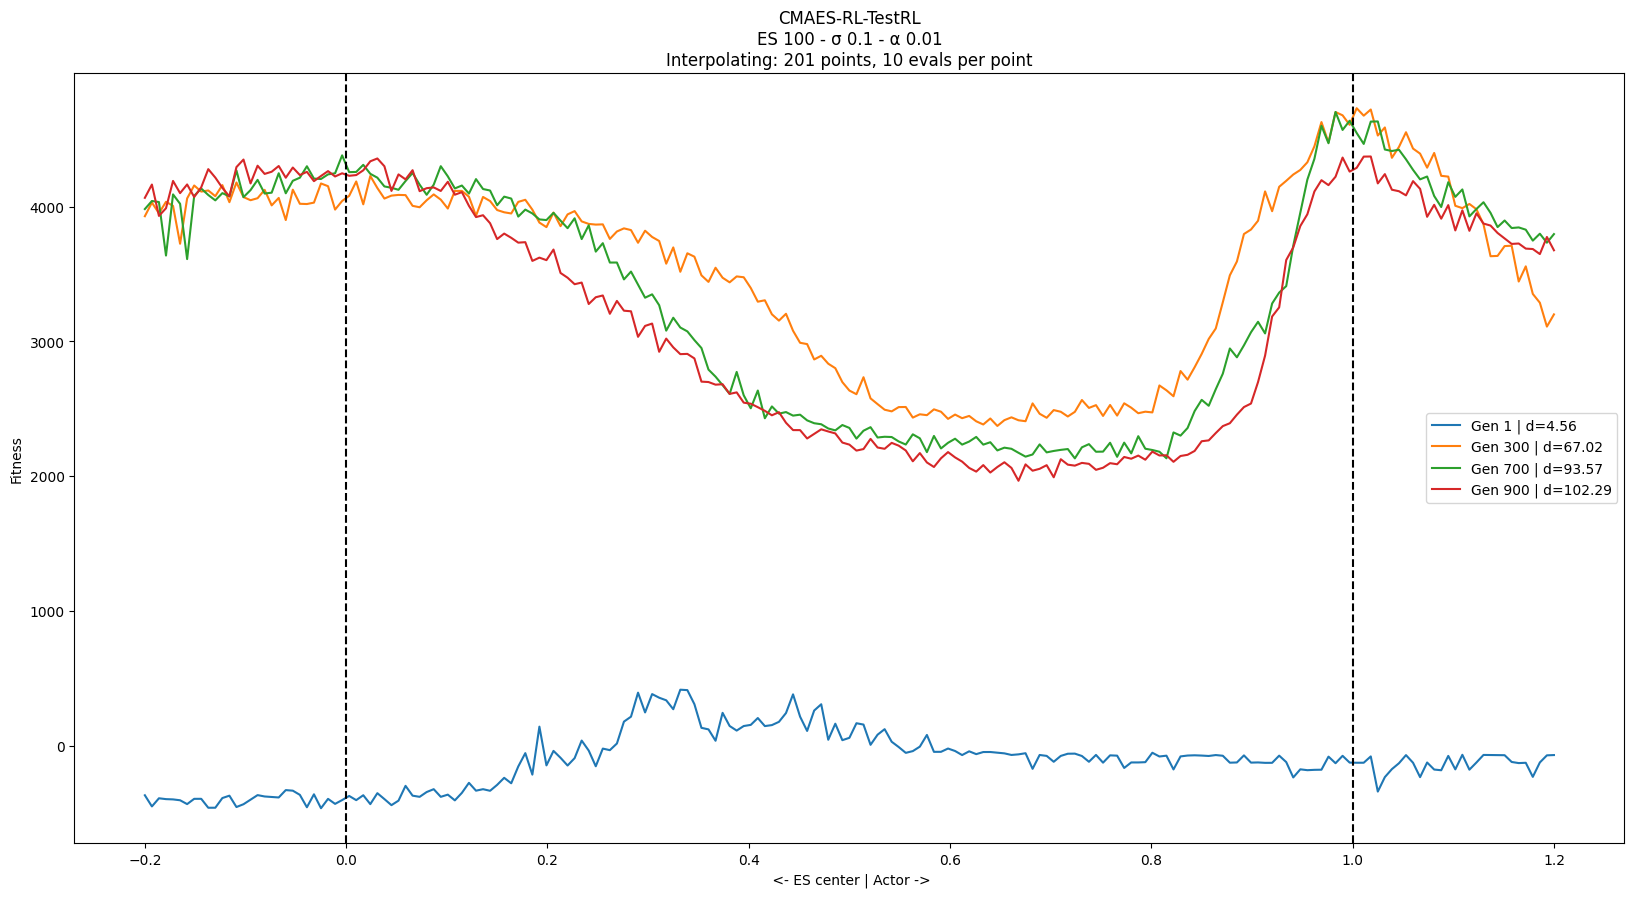

In [91]:
fig, ax = plt.subplots(figsize=(20, 10))

# to_plot = [g for g in gens if g!=1000]
# to_plot = [300, 700]
to_plot = [1, 300, 700, 900]

for gen in to_plot:
    fit = fitnesses[gen]
    dist = distance(save_path, gen)
    plt.plot(base_x, fit, label = f"Gen {gen} | d={dist:.2f}")

# Vertical bar at 0 labeled ES center
plt.axvline(0, color="black", linestyle="--")
# label on x axis under the bar
# plt.text(-0.01, 0.5, "ES center", rotation=90, va="center", ha="center")

# Vertical bar at 1 labeled Actor
plt.axvline(1, color="black", linestyle="--")
# label on x axis under the bar
# plt.text(1.01, 0.5, "Actor", rotation=90, va="center", ha="center")

plt.xlabel(" <- ES center | Actor ->")
plt.ylabel("Fitness")
plt.title(f"{args.algo}\n{args.config}\nInterpolating: {n} points, {n_evals} evals per point")
plt.legend()
plt.show()

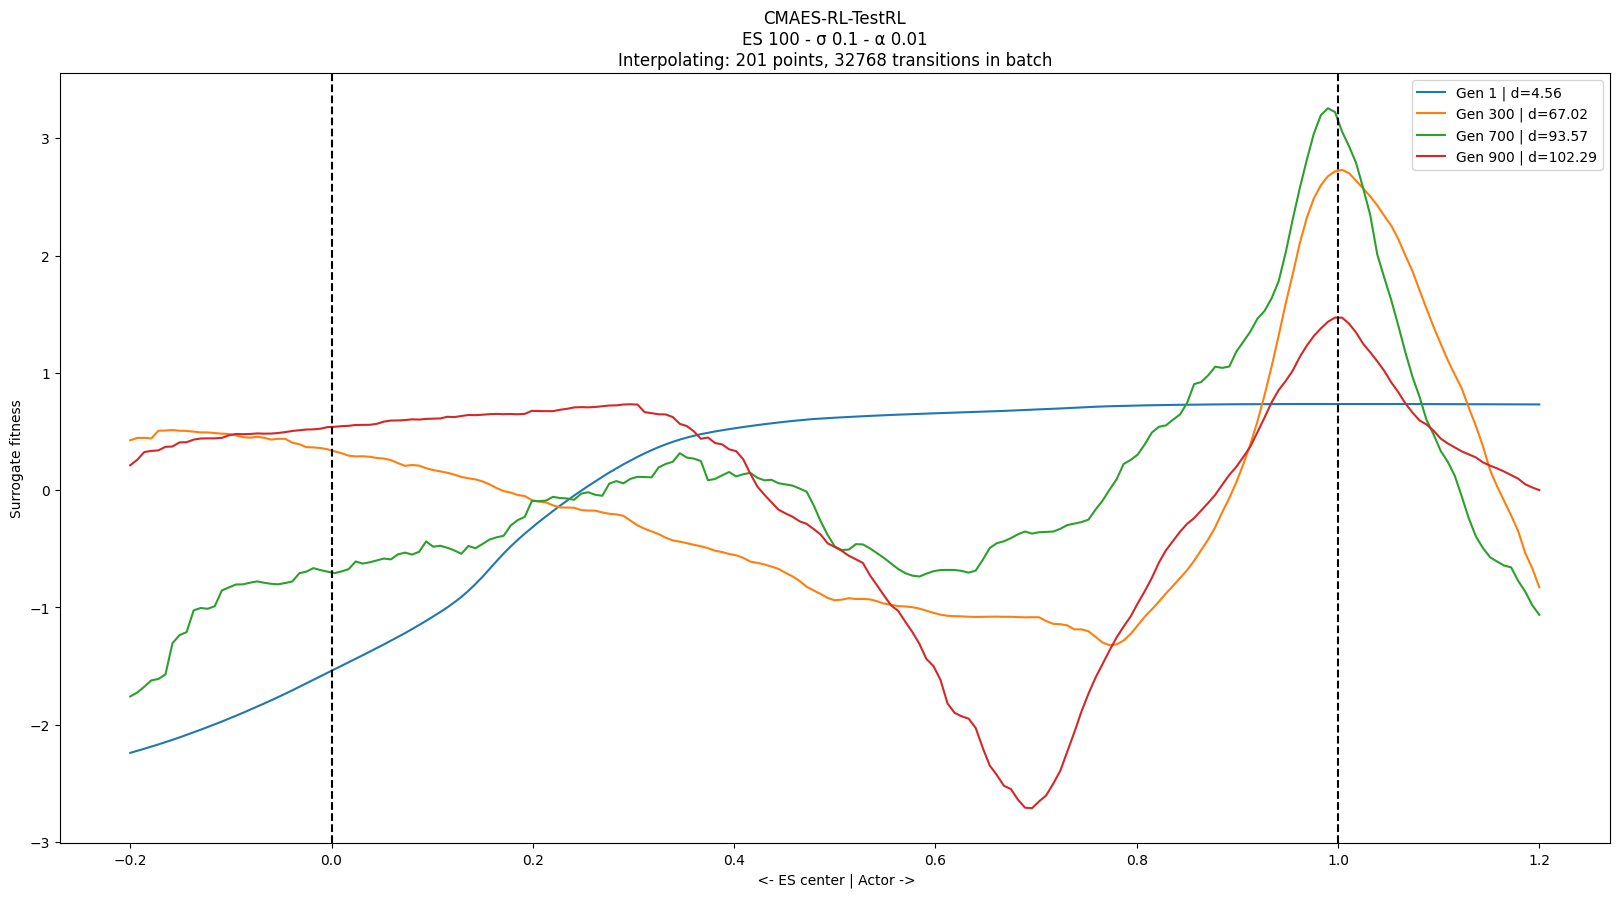

In [92]:
fig, ax = plt.subplots(figsize=(20, 10))

for gen in to_plot:
    fit = surrogate_fit[gen]
    # normalize with mean std
    fit = (fit - fit.mean()) / fit.std()
    dist = distance(save_path, gen)
    plt.plot(base_x, fit, label = f"Gen {gen} | d={dist:.2f}")

# Vertical bar at 0 labeled ES center
plt.axvline(0, color="black", linestyle="--")
# label on x axis under the bar
# plt.text(-0.01, 0.5, "ES center", rotation=90, va="center", ha="center")

# Vertical bar at 1 labeled Actor
plt.axvline(1, color="black", linestyle="--")
# label on x axis under the bar
# plt.text(1.01, 0.5, "Actor", rotation=90, va="center", ha="center")

plt.xlabel(" <- ES center | Actor ->")
plt.ylabel("Surrogate fitness")
plt.title(f"{args.algo}\n{args.config}\nInterpolating: {n} points, {emitter._config.rl_config.surrogate_batch} transitions in batch")
plt.legend()
plt.show()

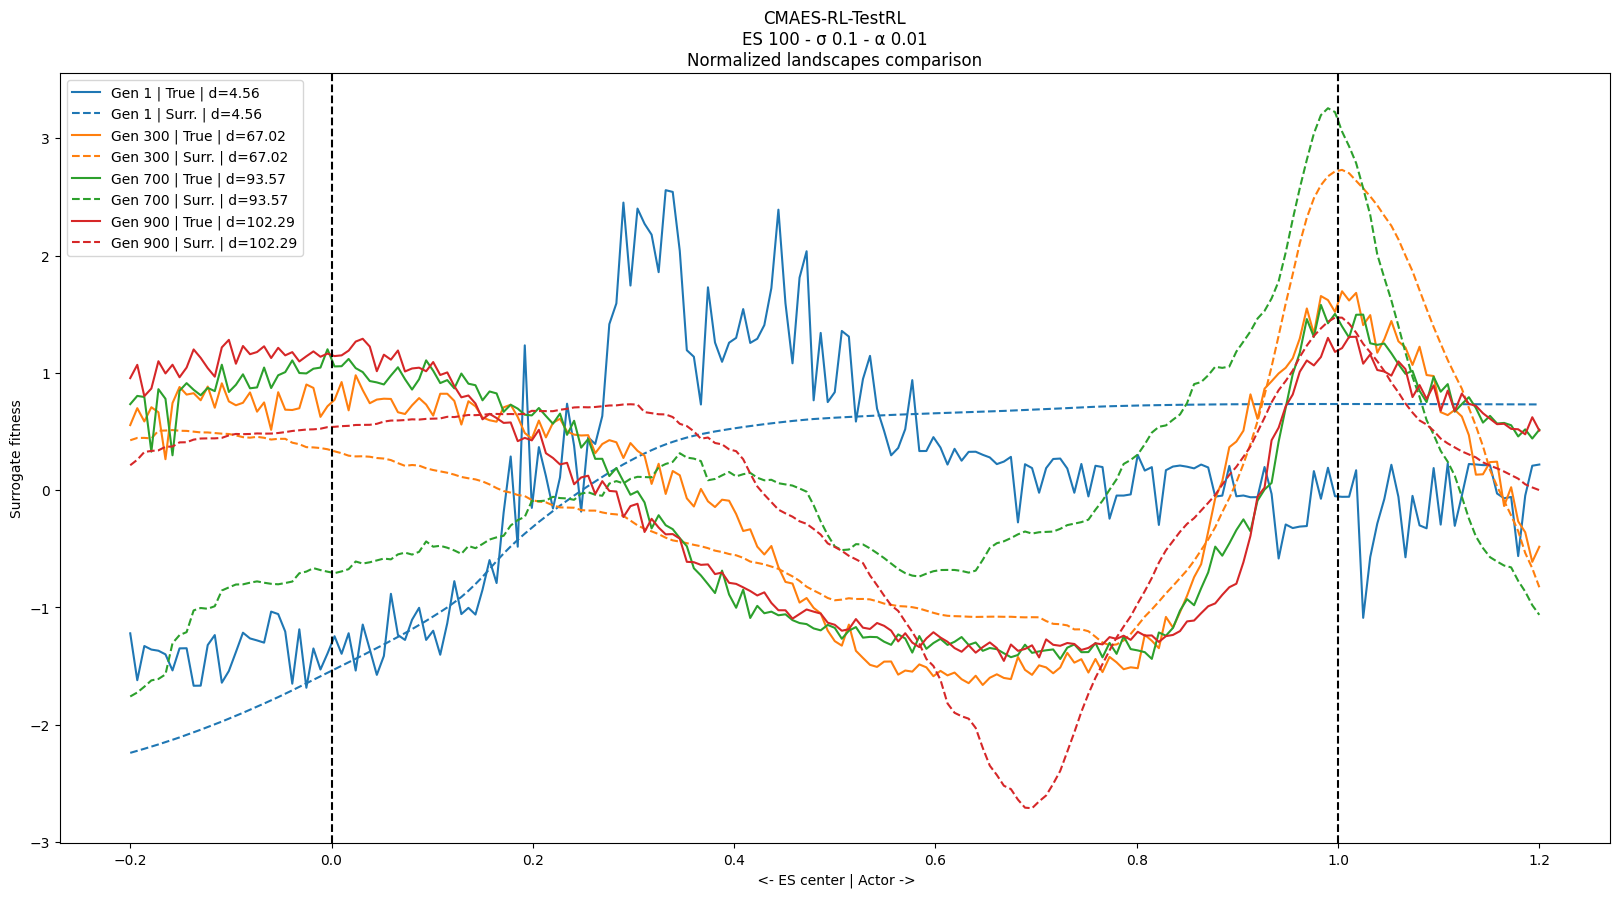

In [94]:
fig, ax = plt.subplots(figsize=(20, 10))

base_x = jnp.linspace(0 - dx, 1 + dx, n)[:, None]


for gen in to_plot:
    # surrogate
    surr_fit = surrogate_fit[gen]
    surr_fit = (surr_fit - surr_fit.mean()) / surr_fit.std()
    
    # true fit
    fit = fitnesses[gen]
    fit = (fit - fit.mean()) / fit.std()

    dist = distance(save_path, gen)
    # Scale x to be between 0 and dist
    # x = base_x * dist
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(base_x, fit, label = f"Gen {gen} | True | d={dist:.2f}", color=color)
    # dotted line with same color
    plt.plot(base_x, surr_fit, label = f"Gen {gen} | Surr. | d={dist:.2f}", linestyle="--", color=color)

# Vertical bar at 0 labeled ES center
plt.axvline(0, color="black", linestyle="--")

# Vertical bar at 1 labeled Actor
plt.axvline(1, color="black", linestyle="--")

plt.xlabel(" <- ES center | Actor ->")
plt.ylabel("Surrogate fitness")
plt.title(f"{args.algo}\n{args.config}\nNormalized landscapes comparison")
plt.legend()
plt.show()

- sample points around ES, eval, rank with fit / surrogate fit 
- same around actor
- compare rankings
- compare surrogate precision around ES and actor

In [76]:
emitter._config.rl_config.surrogate_batch

32768

### Scaled x axis

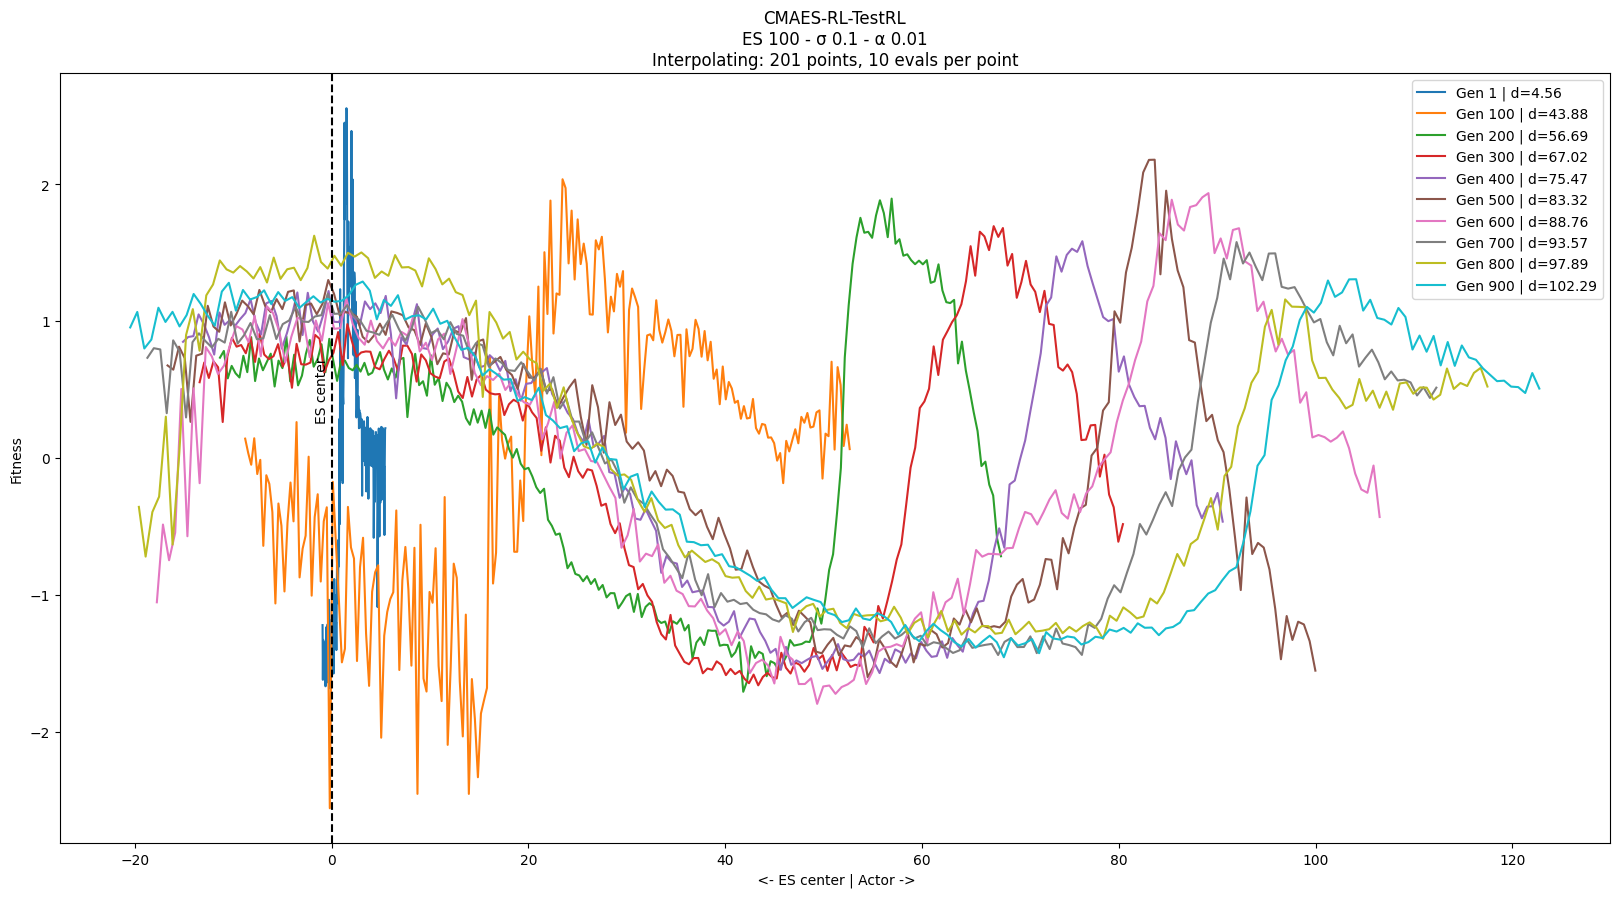

In [80]:
fig, ax = plt.subplots(figsize=(20, 10))

to_plot = gens
to_plot = gens[:-1]
# to_plot = [1, 300, 700]

base_x = jnp.linspace(0 - dx, 1 + dx, n)[:, None]

for gen in to_plot:
    fit = fitnesses[gen]
    fit = (fit - fit.mean()) / fit.std()
    dist = distance(save_path, gen)
    # Scale x to be between 0 and dist
    x = base_x * dist
    plt.plot(x, fit, label = f"Gen {gen} | d={dist:.2f}")

# Vertical bar at 0 labeled ES center
plt.axvline(0, color="black", linestyle="--")
# label on x axis under the bar
plt.text(-1, 0.5, "ES center", rotation=90, va="center", ha="center")

plt.xlabel(" <- ES center | Actor ->")
plt.ylabel("Fitness")
plt.title(f"{args.algo}\n{args.config}\nInterpolating: {n} points, {n_evals} evals per point")
plt.legend()
plt.show()

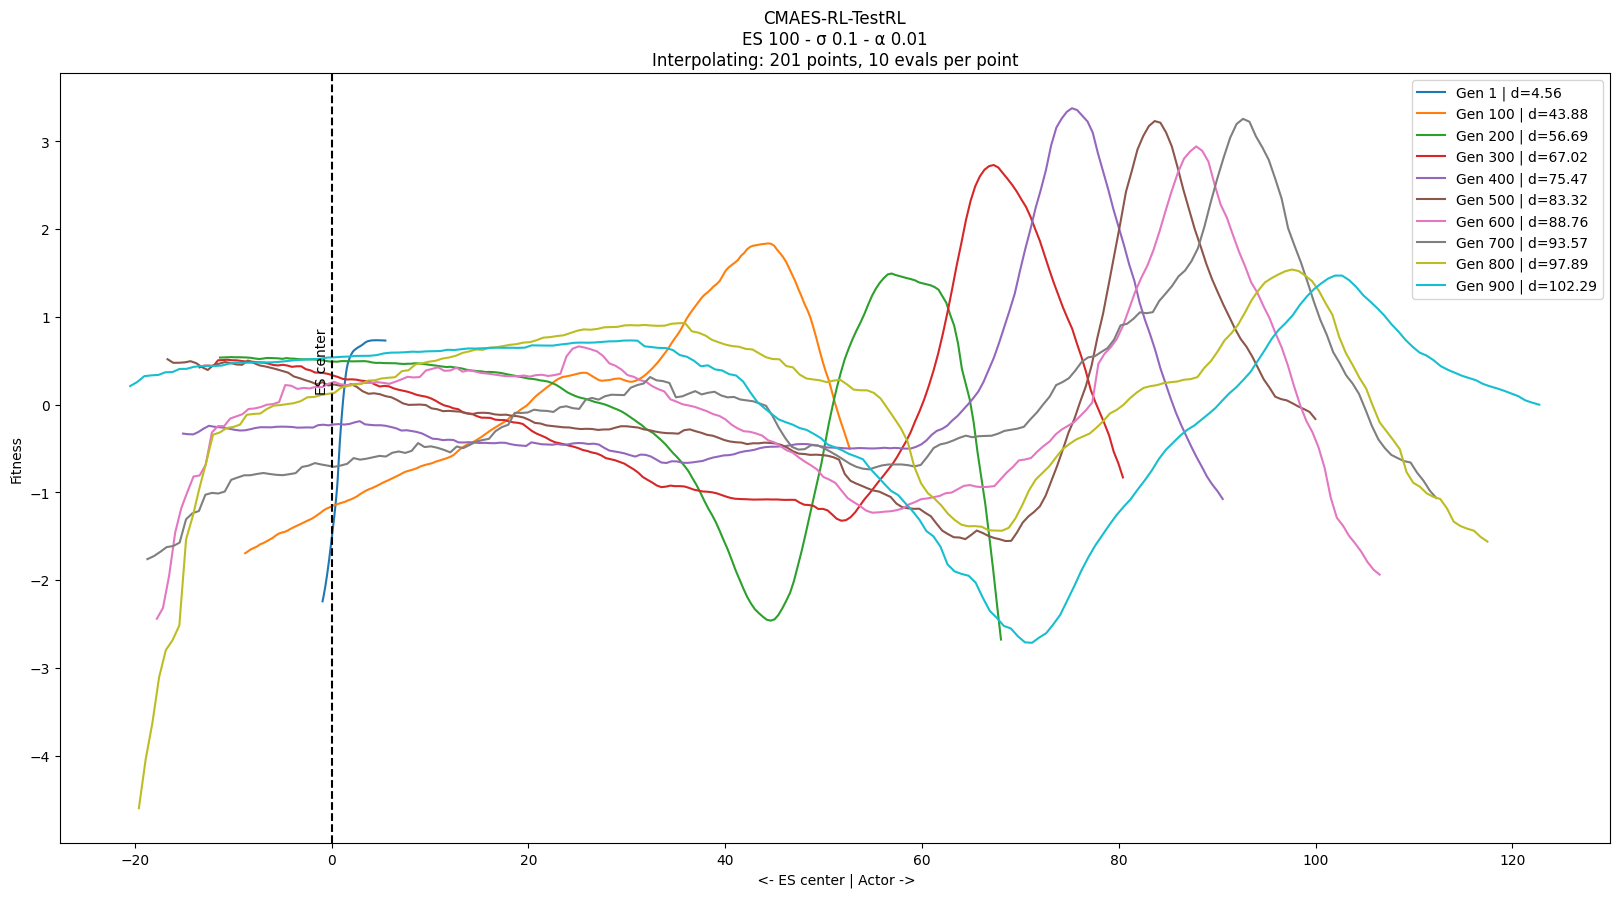

In [79]:
fig, ax = plt.subplots(figsize=(20, 10))

# to_plot = gens
# to_plot = gens[:-1]
# to_plot = [1, 300, 700]

base_x = jnp.linspace(0 - dx, 1 + dx, n)[:, None]

for gen in to_plot:
    fit = surrogate_fit[gen]
    # normalize with mean std
    fit = (fit - fit.mean()) / fit.std()
    
    dist = distance(save_path, gen)
    # Scale x to be between 0 and dist
    x = base_x * dist
    plt.plot(x, fit, label = f"Gen {gen} | d={dist:.2f}")

# Vertical bar at 0 labeled ES center
plt.axvline(0, color="black", linestyle="--")
# label on x axis under the bar
plt.text(-1, 0.5, "ES center", rotation=90, va="center", ha="center")

plt.xlabel(" <- ES center | Actor ->")
plt.ylabel("Fitness")
plt.title(f"{args.algo}\n{args.config}\nInterpolating: {n} points, {n_evals} evals per point")
plt.legend()
plt.show()

In [1]:
args.algo, args.config

1

### Local landscapes

In [49]:
def get_weights(fitnesses):
    ranks = jnp.argsort(fitnesses, axis=0)
    ranks = len(ranks) - ranks # Reverse the ranks (best is now 0)
    mu = len(ranks) // 2
    weights = jnp.where(ranks <= mu, jnp.log(mu+0.5) - jnp.log(ranks), 0) 
    weights /= jnp.sum(weights) # Normalizing the weights
    return weights

In [78]:
def local_weights(center, sigma, critic, base_buffer, n=100):
    genomes = jax.random.normal(jax.random.PRNGKey(0), shape=(n, *center.shape)) * sigma + center
    # True eval
    fit, replay_buffer = batch_eval(genomes, n_evals=1, buffer=base_buffer)

    # Surrogate eval
    full_rl_state = emitter_state.rl_state.replace(
        replay_buffer=replay_buffer,
        critic_params=critic,
        )

    full_emitter_state = emitter_state.replace(rl_state=full_rl_state)

    surr_fit = surrogate_eval(genomes, full_emitter_state)

    fit_w = get_weights(fit)
    surr_fit_w = get_weights(surr_fit)

    # Random fitnesses
    random_fit = jax.random.normal(jax.random.PRNGKey(0), shape=(n,))
    random_w = get_weights(random_fit)

    multi_fit, replay_buffer = batch_eval(genomes, n_evals=20, buffer=base_buffer)
    multi_w = get_weights(multi_fit)

    return {
        "fit": fit_w,
        "multi": multi_w,
        "surr_fit": surr_fit_w,
        "random": random_w,
    }
        

In [83]:
gens = [1, 100, 200, 300, 400, 500, 600, 700, 800 ,900, 1000]
base_replay_buffer = emitter_state.rl_state.replay_buffer

sigma = 0.01

off_results = {}
actor_results = {}

for gen in gens:
    print("Gen", gen)
    
    critic_genes = jnp.load(save_path + f"/gen_{gen}_critic.npy")
    critic = emitter.rl_emitter.unflatten_critic(critic_genes)

    offspring_genes = jnp.load(save_path + f"/gen_{gen}_offspring.npy")
    actor_genes = jnp.load(save_path + f"/gen_{gen}_actor.npy")

    # Offspring
    off_results[gen] = local_weights(offspring_genes, sigma, critic, base_replay_buffer)
    actor_results[gen] = local_weights(actor_genes, sigma, critic, base_replay_buffer)

Gen 1
1 batches of 1 evaluations each. Total: 1


100%|██████████| 1/1 [00:02<00:00,  2.98s/it]


1 batches of 20 evaluations each. Total: 20


100%|██████████| 1/1 [00:04<00:00,  4.05s/it]


1 batches of 1 evaluations each. Total: 1


100%|██████████| 1/1 [00:02<00:00,  2.94s/it]


1 batches of 20 evaluations each. Total: 20


100%|██████████| 1/1 [00:04<00:00,  4.03s/it]


Gen 100
1 batches of 1 evaluations each. Total: 1


100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


1 batches of 20 evaluations each. Total: 20


100%|██████████| 1/1 [00:04<00:00,  4.02s/it]


1 batches of 1 evaluations each. Total: 1


100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


1 batches of 20 evaluations each. Total: 20


100%|██████████| 1/1 [00:04<00:00,  4.01s/it]


Gen 200
1 batches of 1 evaluations each. Total: 1


100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


1 batches of 20 evaluations each. Total: 20


100%|██████████| 1/1 [00:04<00:00,  4.04s/it]


1 batches of 1 evaluations each. Total: 1


100%|██████████| 1/1 [00:02<00:00,  2.94s/it]


1 batches of 20 evaluations each. Total: 20


100%|██████████| 1/1 [00:04<00:00,  4.06s/it]


Gen 300
1 batches of 1 evaluations each. Total: 1


100%|██████████| 1/1 [00:02<00:00,  2.94s/it]


1 batches of 20 evaluations each. Total: 20


100%|██████████| 1/1 [00:04<00:00,  4.05s/it]


1 batches of 1 evaluations each. Total: 1


100%|██████████| 1/1 [00:02<00:00,  2.94s/it]


1 batches of 20 evaluations each. Total: 20


100%|██████████| 1/1 [00:04<00:00,  4.03s/it]


Gen 400
1 batches of 1 evaluations each. Total: 1


100%|██████████| 1/1 [00:02<00:00,  2.94s/it]


1 batches of 20 evaluations each. Total: 20


100%|██████████| 1/1 [00:04<00:00,  4.06s/it]


1 batches of 1 evaluations each. Total: 1


100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


1 batches of 20 evaluations each. Total: 20


100%|██████████| 1/1 [00:04<00:00,  4.07s/it]


Gen 500
1 batches of 1 evaluations each. Total: 1


100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


1 batches of 20 evaluations each. Total: 20


100%|██████████| 1/1 [00:04<00:00,  4.06s/it]


1 batches of 1 evaluations each. Total: 1


100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


1 batches of 20 evaluations each. Total: 20


100%|██████████| 1/1 [00:04<00:00,  4.07s/it]


Gen 600
1 batches of 1 evaluations each. Total: 1


100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


1 batches of 20 evaluations each. Total: 20


100%|██████████| 1/1 [00:04<00:00,  4.07s/it]


1 batches of 1 evaluations each. Total: 1


100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


1 batches of 20 evaluations each. Total: 20


100%|██████████| 1/1 [00:04<00:00,  4.07s/it]


Gen 700
1 batches of 1 evaluations each. Total: 1


100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


1 batches of 20 evaluations each. Total: 20


100%|██████████| 1/1 [00:04<00:00,  4.05s/it]


1 batches of 1 evaluations each. Total: 1


100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


1 batches of 20 evaluations each. Total: 20


100%|██████████| 1/1 [00:04<00:00,  4.06s/it]


Gen 800
1 batches of 1 evaluations each. Total: 1


100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


1 batches of 20 evaluations each. Total: 20


100%|██████████| 1/1 [00:04<00:00,  4.07s/it]


1 batches of 1 evaluations each. Total: 1


100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


1 batches of 20 evaluations each. Total: 20


100%|██████████| 1/1 [00:04<00:00,  4.07s/it]


Gen 900
1 batches of 1 evaluations each. Total: 1


100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


1 batches of 20 evaluations each. Total: 20


100%|██████████| 1/1 [00:04<00:00,  4.08s/it]


1 batches of 1 evaluations each. Total: 1


100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


1 batches of 20 evaluations each. Total: 20


100%|██████████| 1/1 [00:04<00:00,  4.09s/it]


Gen 1000
1 batches of 1 evaluations each. Total: 1


100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


1 batches of 20 evaluations each. Total: 20


100%|██████████| 1/1 [00:04<00:00,  4.12s/it]


1 batches of 1 evaluations each. Total: 1


100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


1 batches of 20 evaluations each. Total: 20


100%|██████████| 1/1 [00:04<00:00,  4.12s/it]


Text(0.5, 1.0, 'MSE between surrogate weights and true weights')

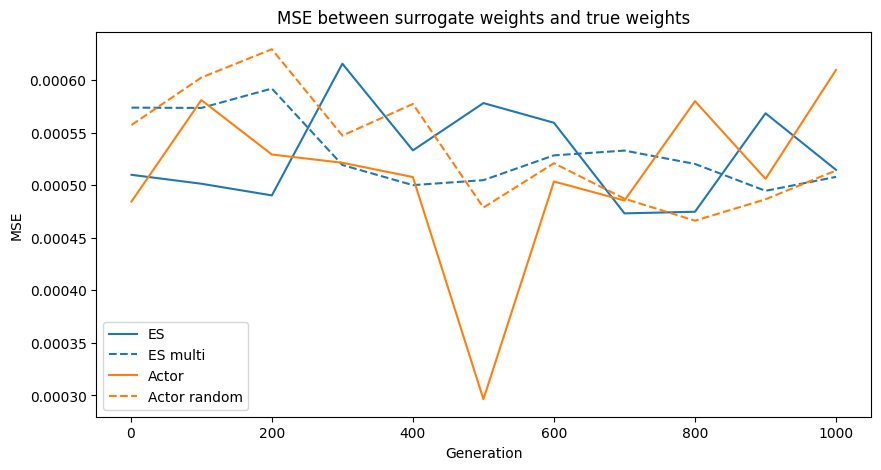

In [84]:
fig, ax = plt.subplots(figsize=(10, 5))
# x axis: gens
# y axis: mse

def mse(a, b):
    return jnp.mean((a - b)**2)

es_mse = [mse(x["multi"], x["surr_fit"]) for x in off_results.values()]
es_multi_mse = [mse(x["multi"], x["fit"]) for x in off_results.values()]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.plot(gens, es_mse, label="ES", color=colors[0])
plt.plot(gens, es_multi_mse, label="ES multi", color=colors[0], linestyle="--")

ac_mse = [mse(x["multi"], x["surr_fit"]) for x in actor_results.values()]
ac_multi_mse = [mse(x["multi"], x["fit"]) for x in actor_results.values()]

plt.plot(gens, ac_mse, label="Actor", color=colors[1])
plt.plot(gens, ac_multi_mse, label="Actor random", color=colors[1], linestyle="--")


plt.xlabel("Generation")
plt.ylabel("MSE")
plt.legend()
plt.title("MSE between surrogate weights and true weights")

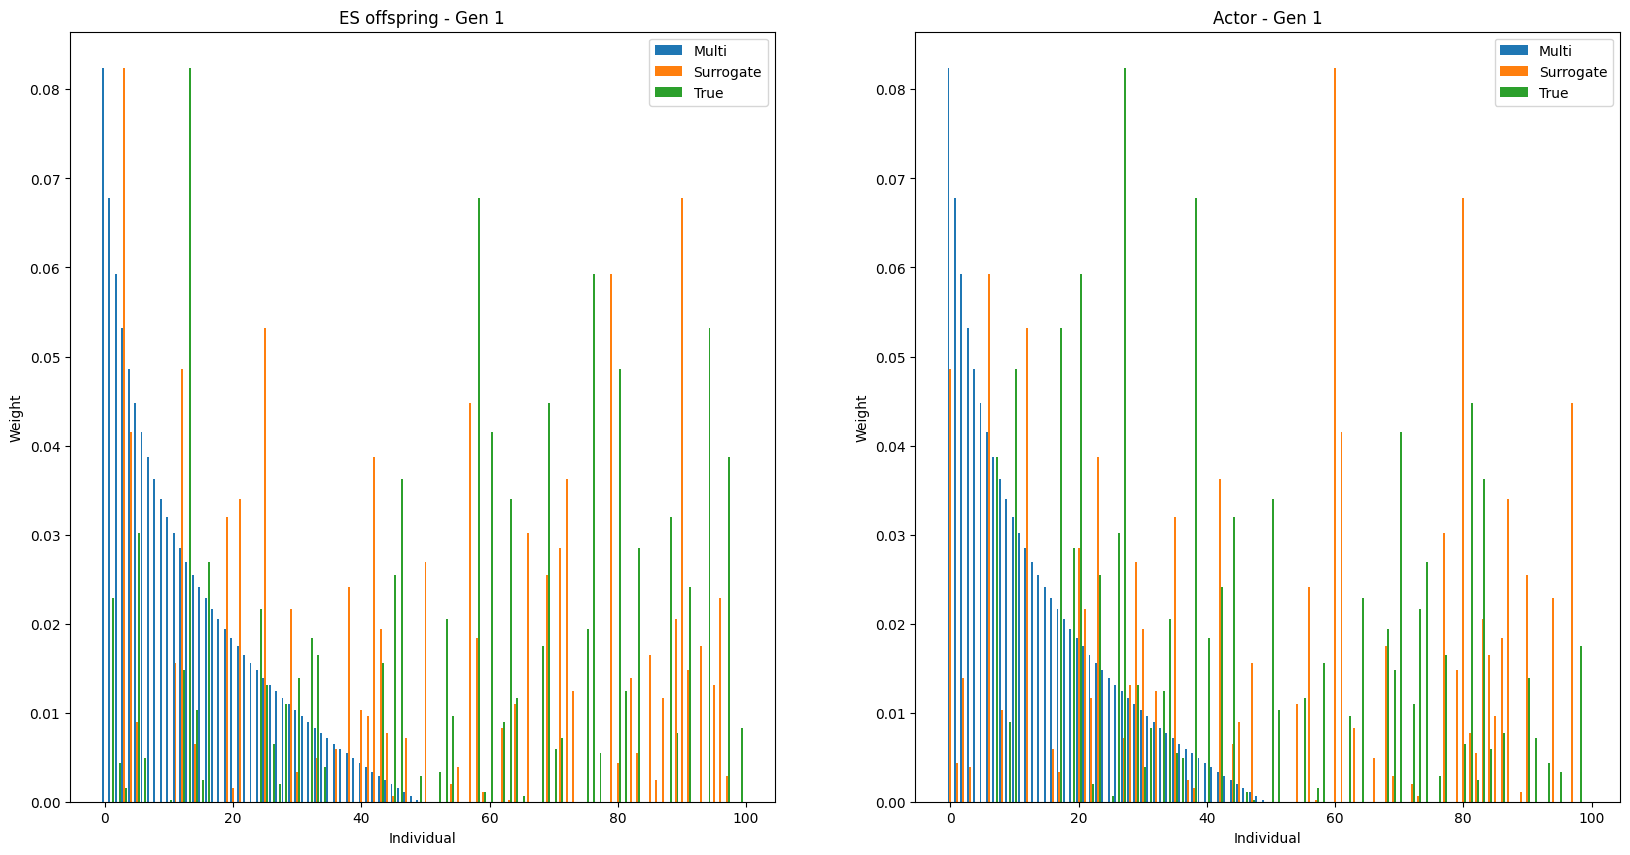

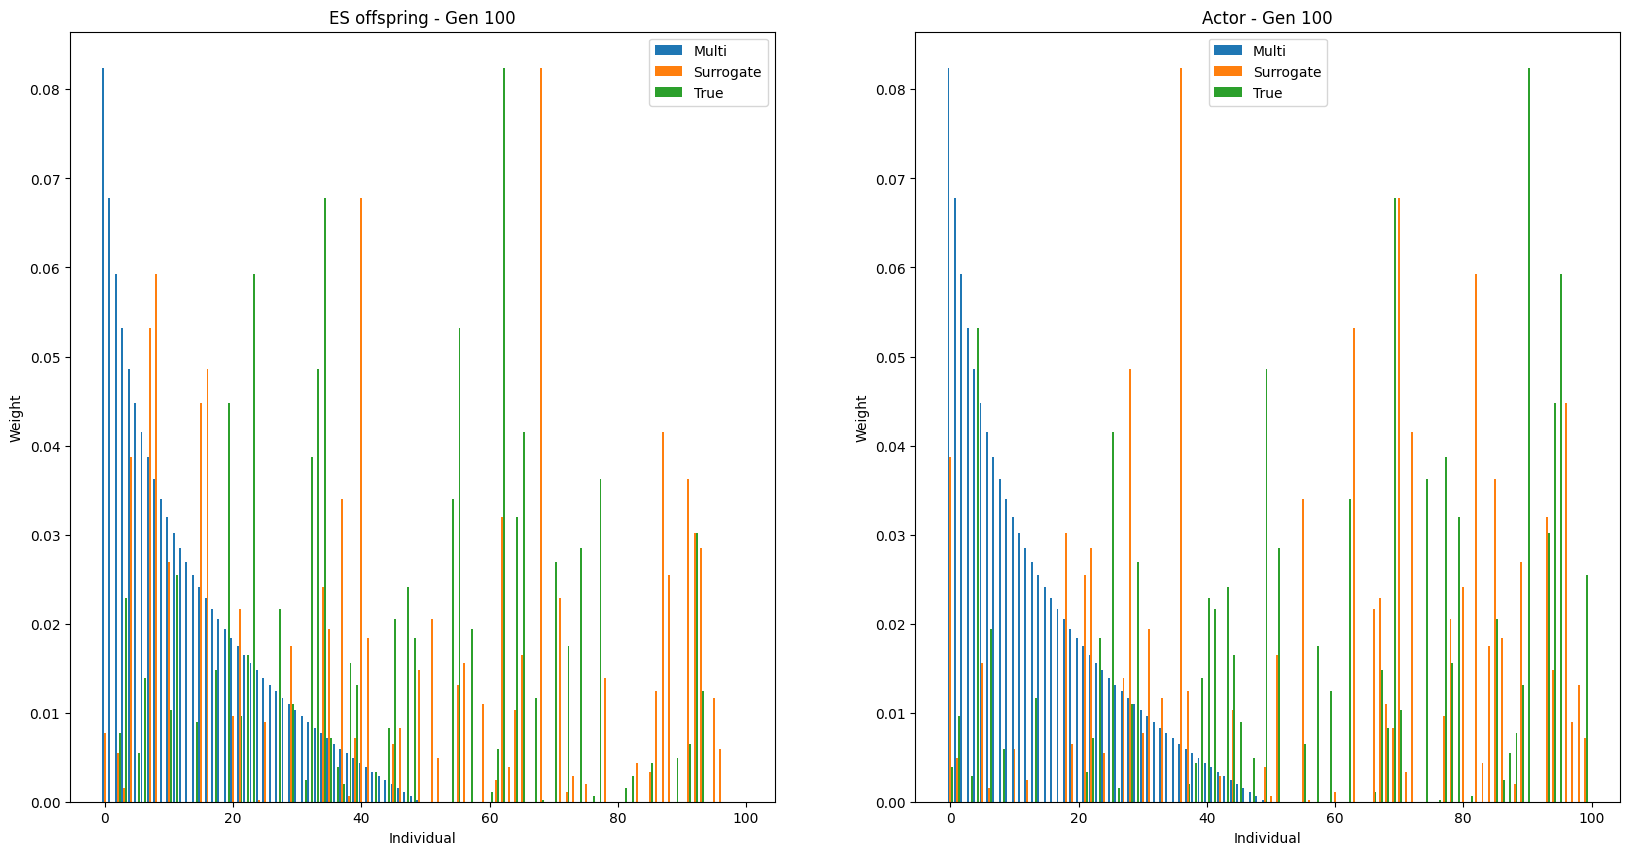

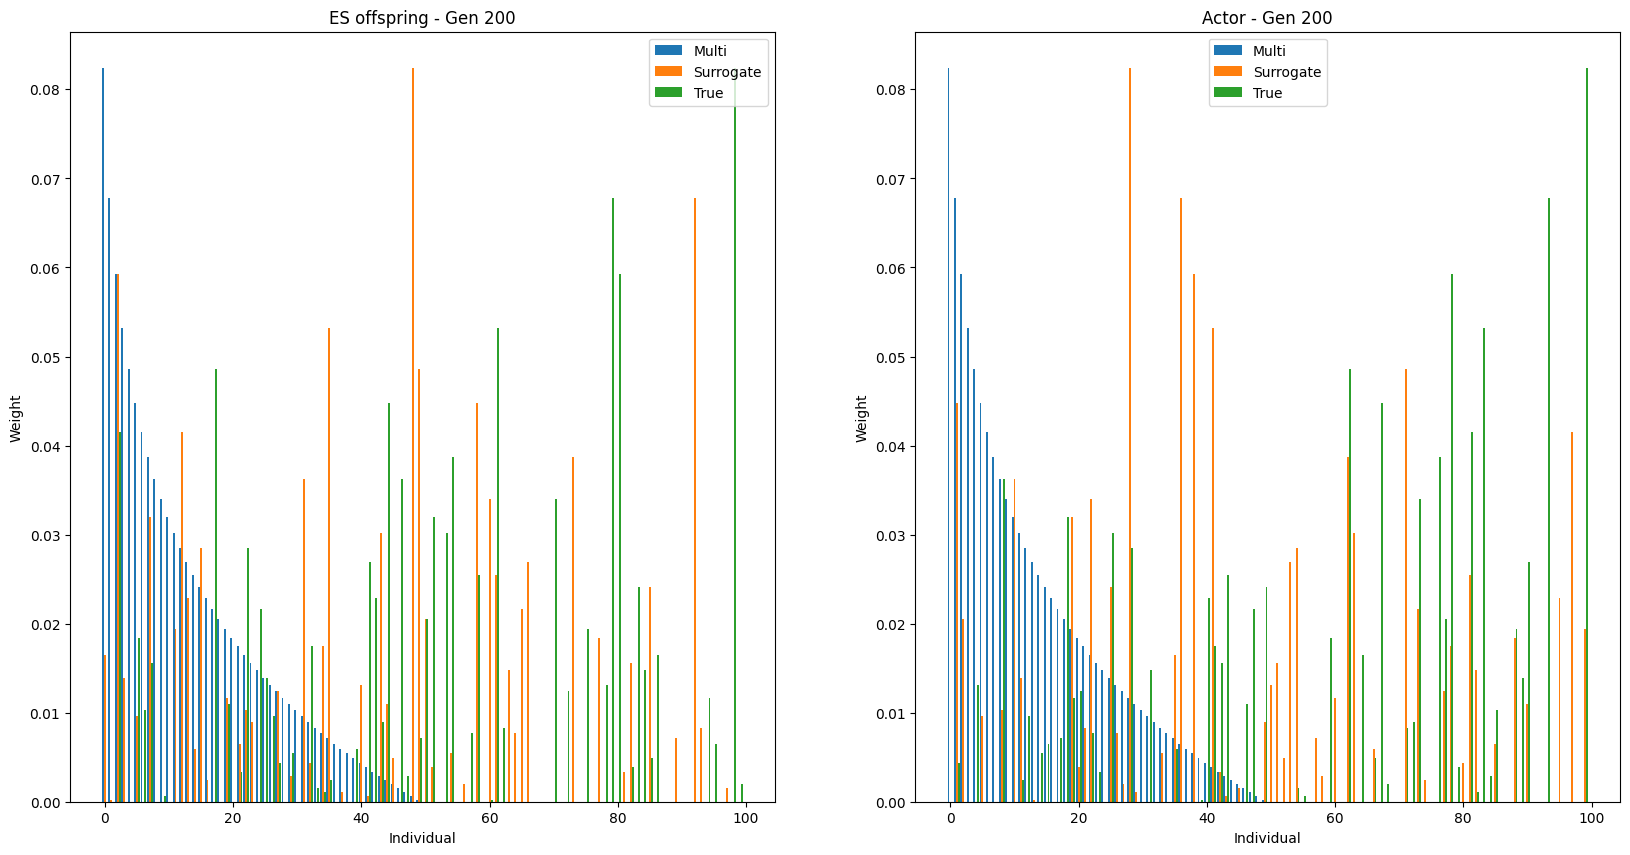

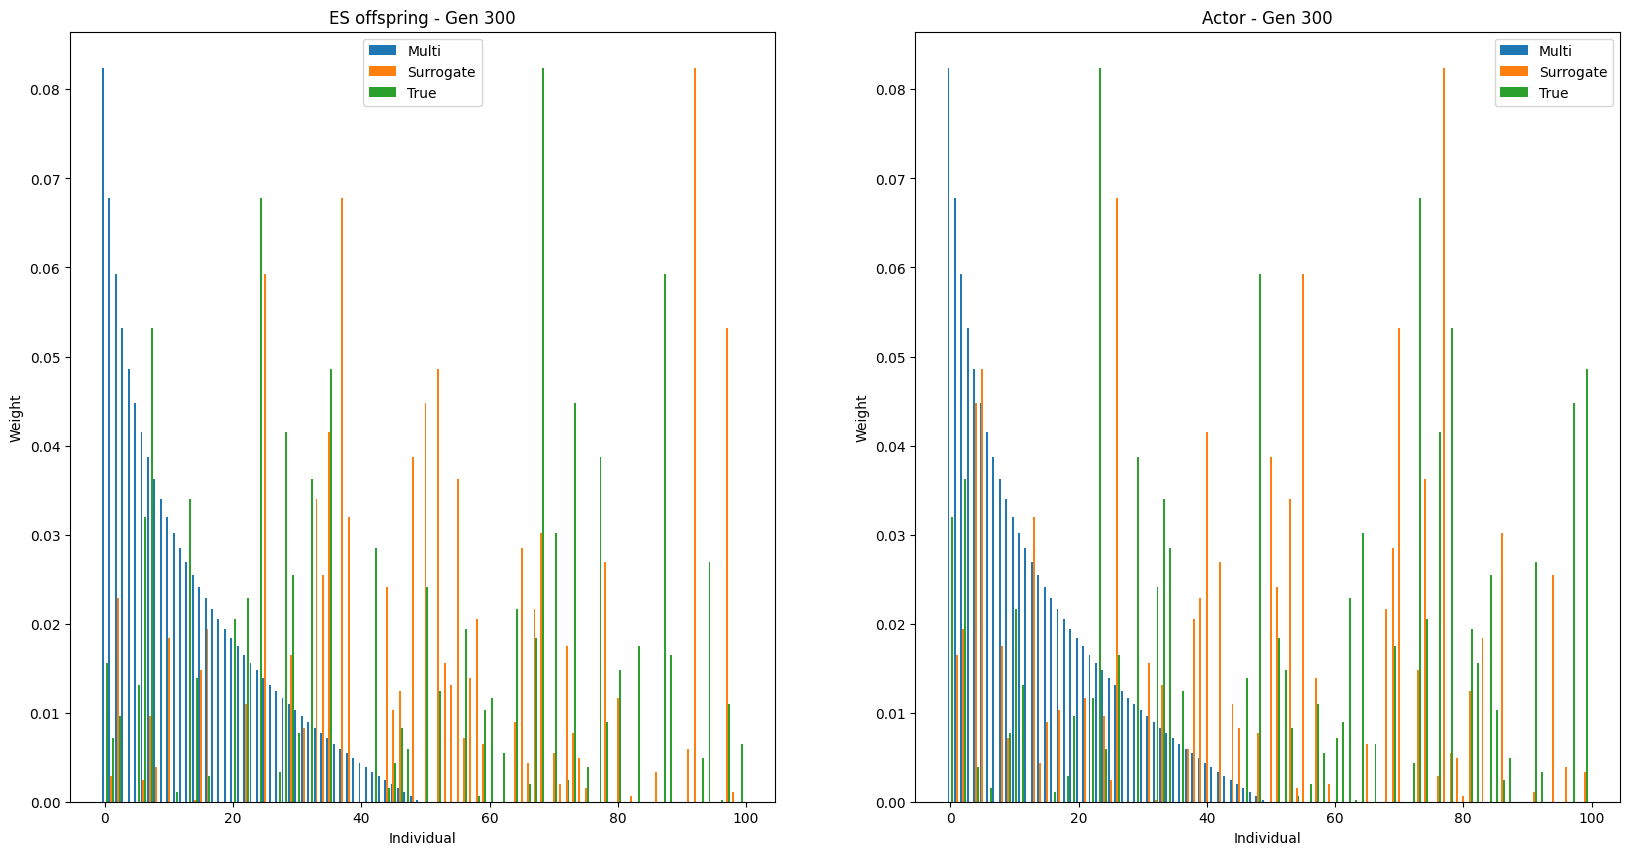

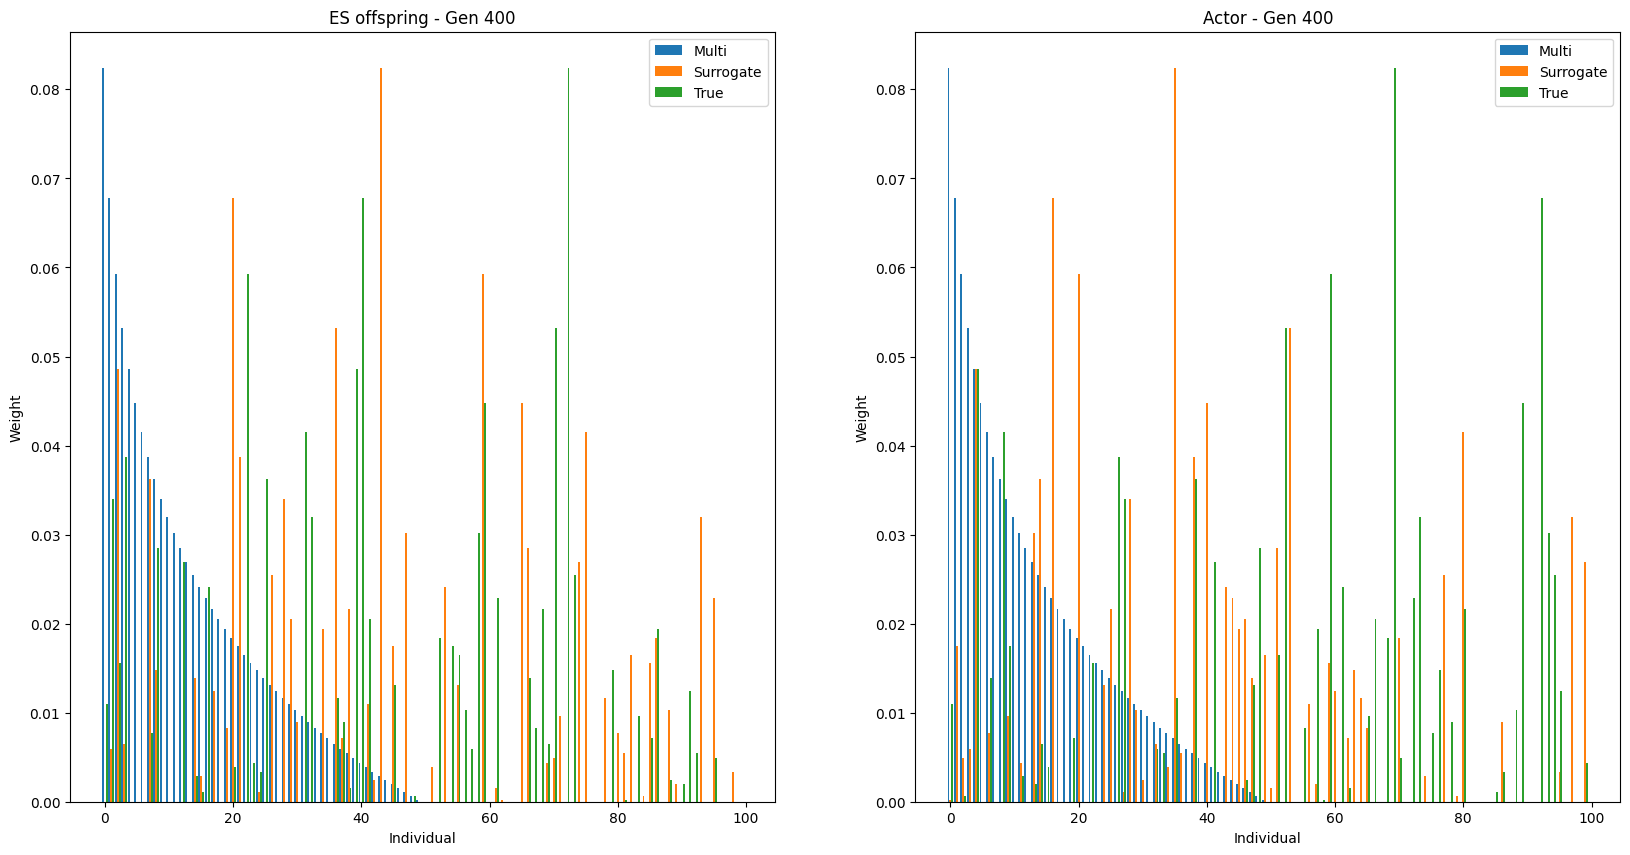

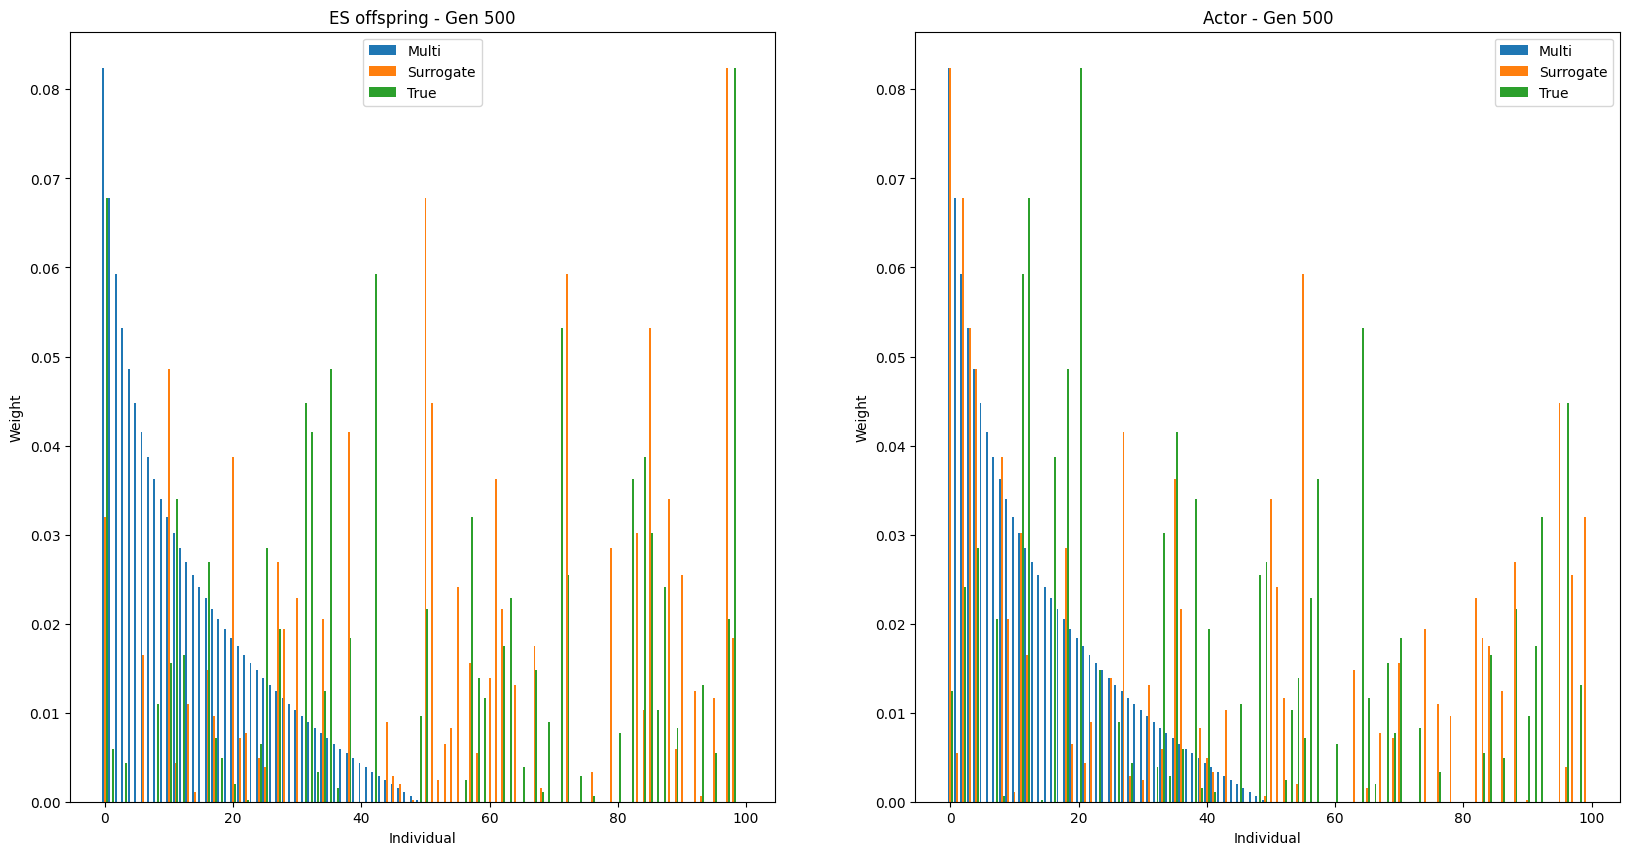

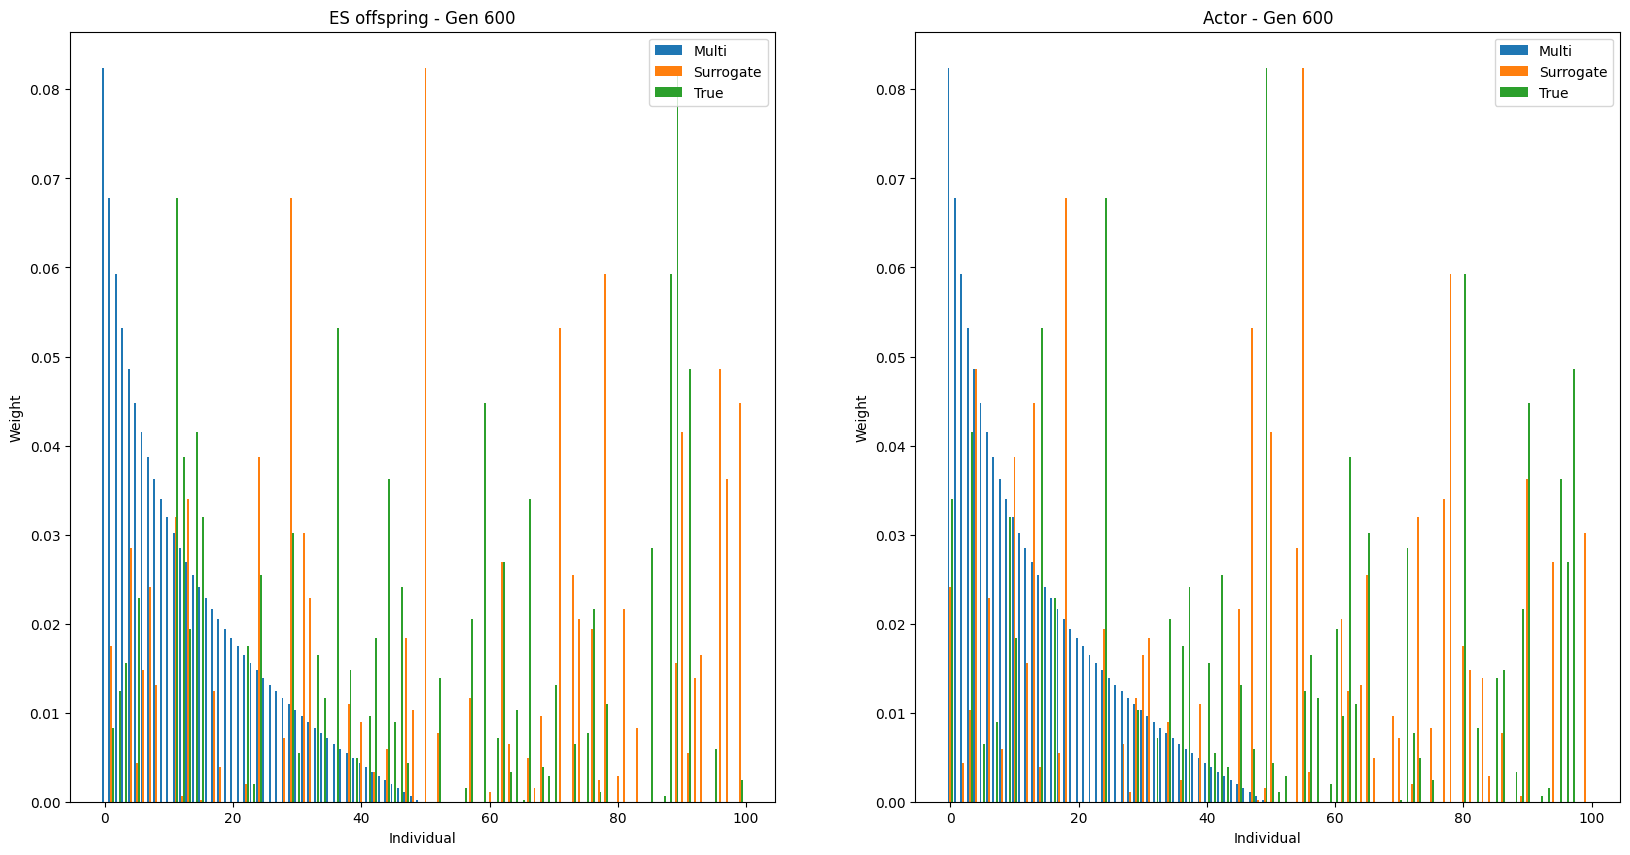

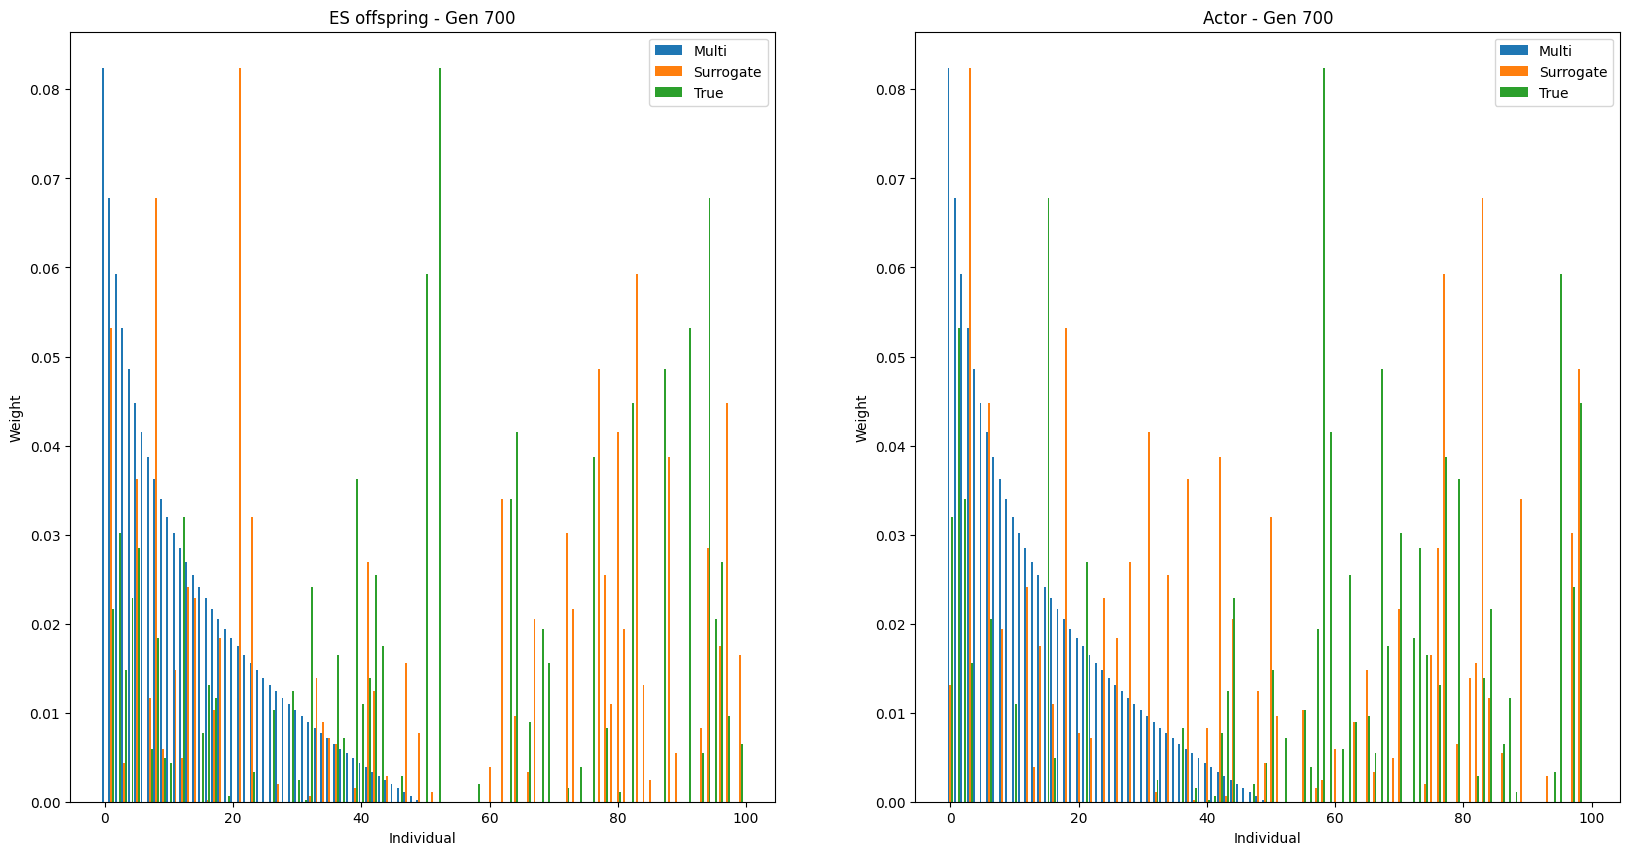

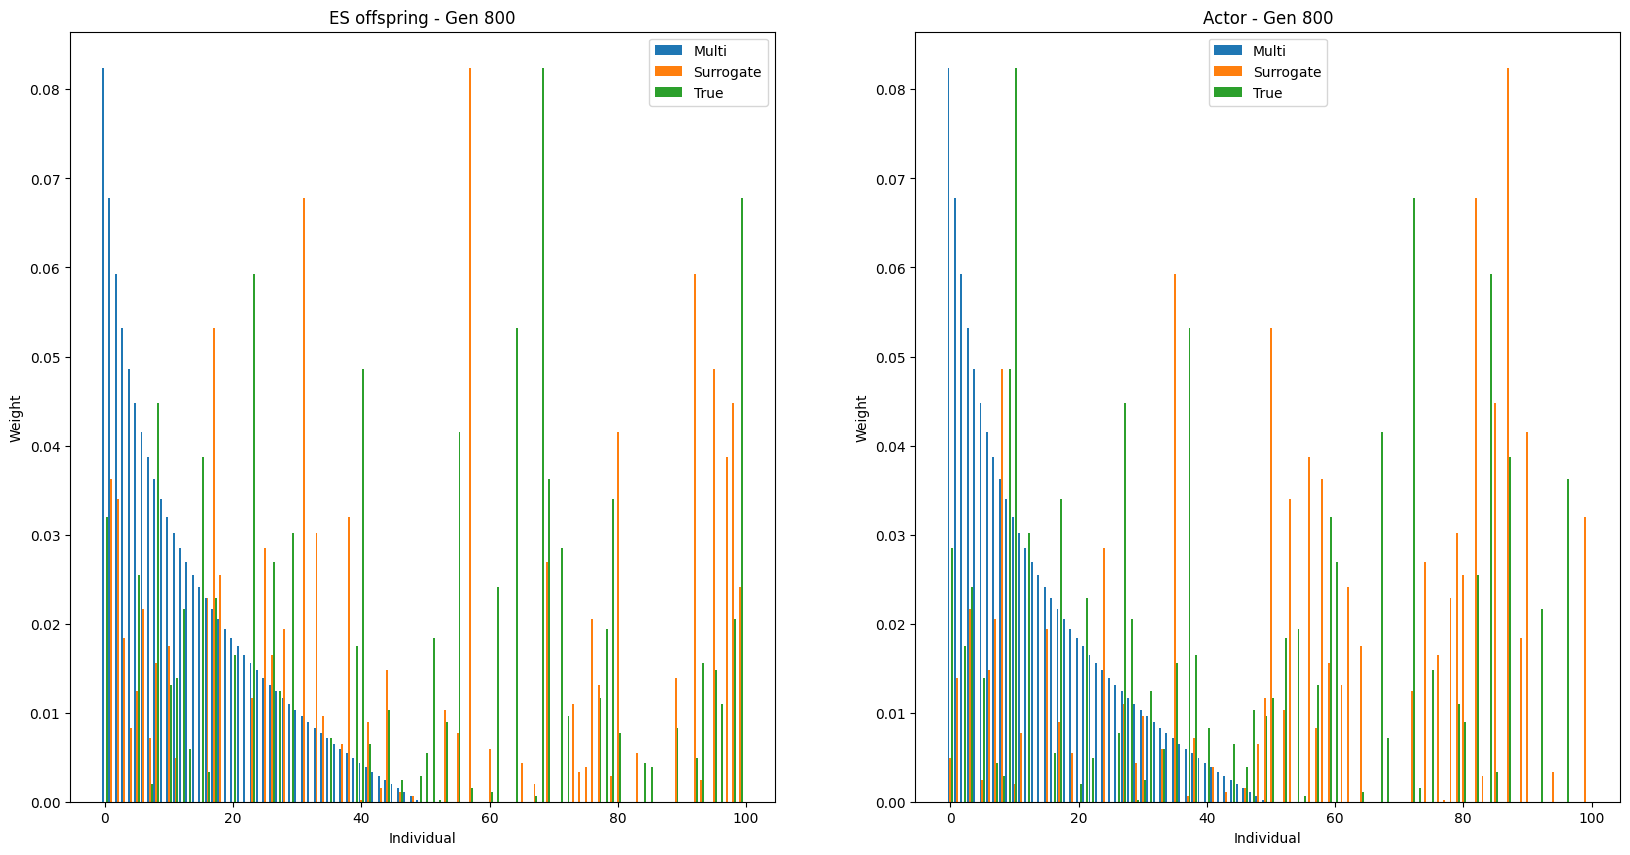

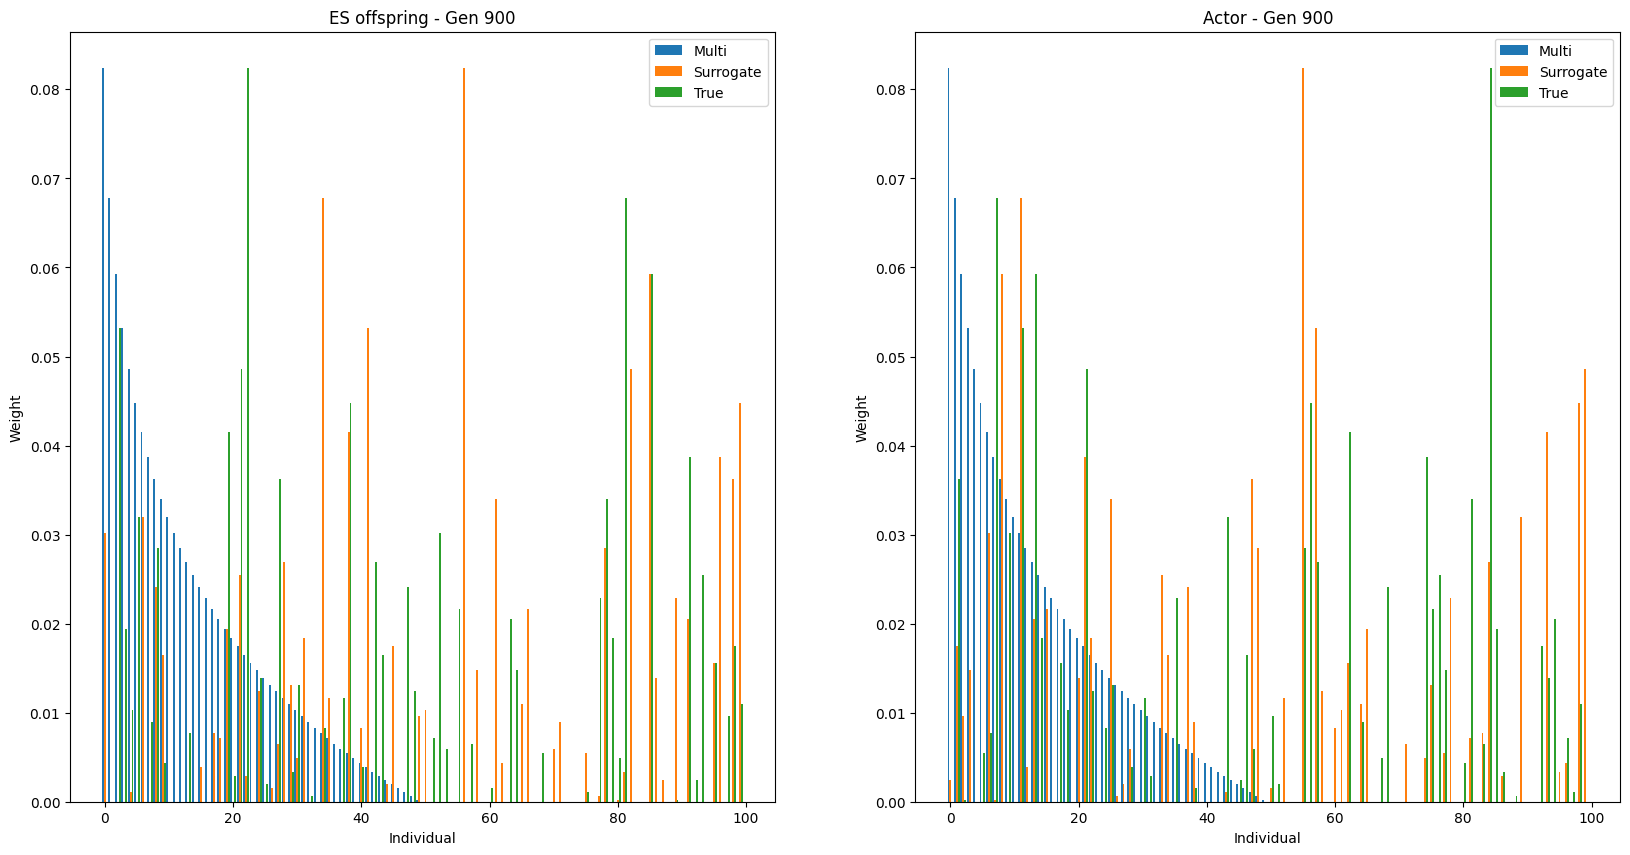

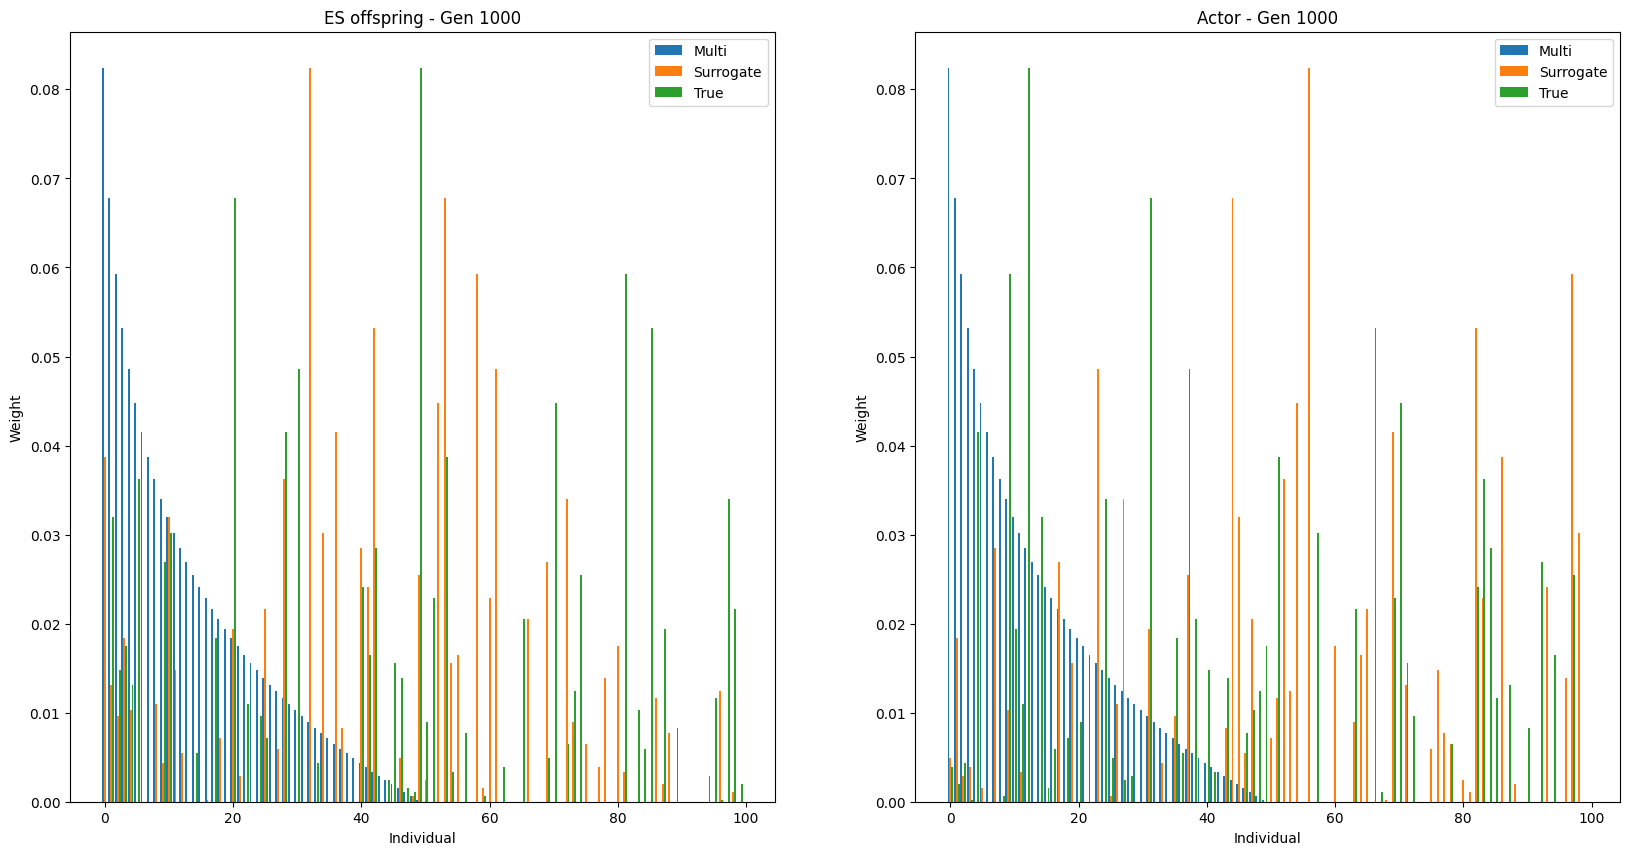

In [94]:
# gen = 100

results = off_results
results = actor_results

for gen in gens:
    # 2 subplots: ES offspring, ES actor

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    for i, results, title in [(0, off_results, "ES offspring"), (1, actor_results, "Actor")]:
        multi_fit = results[gen]["multi"]
        surr_fit = results[gen]["surr_fit"]
        fit = results[gen]["fit"]

        # reorder both to be in the same order, with fit decreasing
        order = jnp.argsort(multi_fit)[::-1]
        multi_fit = multi_fit[order]
        fit = fit[order]
        surr_fit = surr_fit[order]

        # Bar plot with 3 bars every time
        # x axis: individual
        # y axis: weight
        # Left subplot
        width = 0.3
        x = jnp.arange(len(multi_fit))
        ax[i].bar(x - width, multi_fit, width, label="Multi")
        ax[i].bar(x, surr_fit, width, label="Surrogate")
        ax[i].bar(x + width, fit, width, label="True")
        
        ax[i].set_title(f"{title} - Gen {gen}")
        ax[i].set_xlabel("Individual")
        ax[i].set_ylabel("Weight")
        ax[i].legend()
    plt.show()



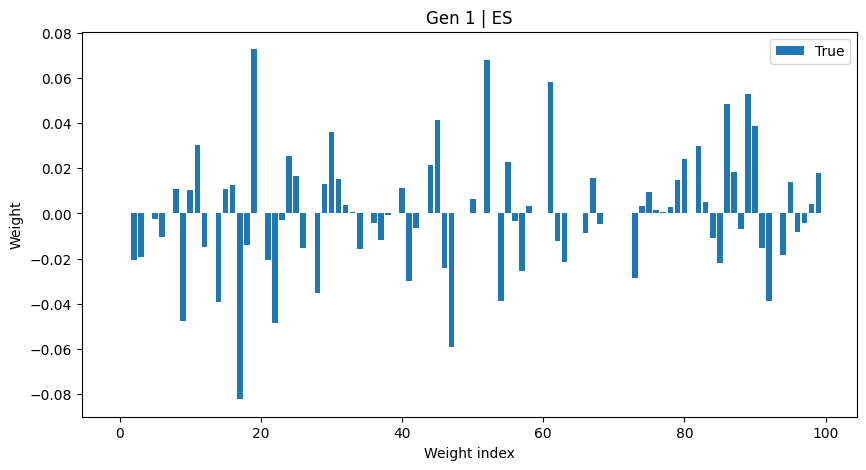

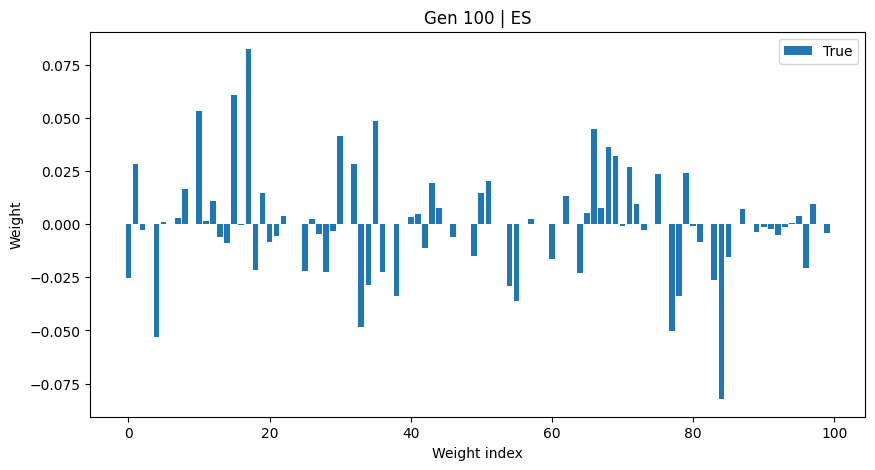

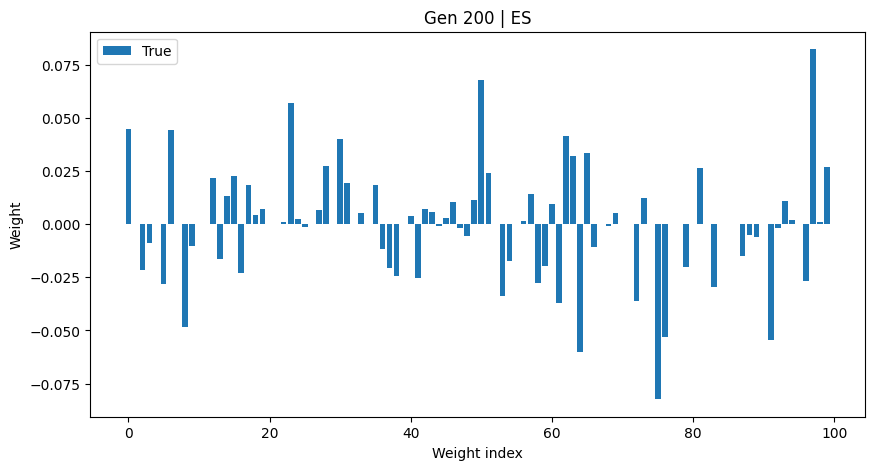

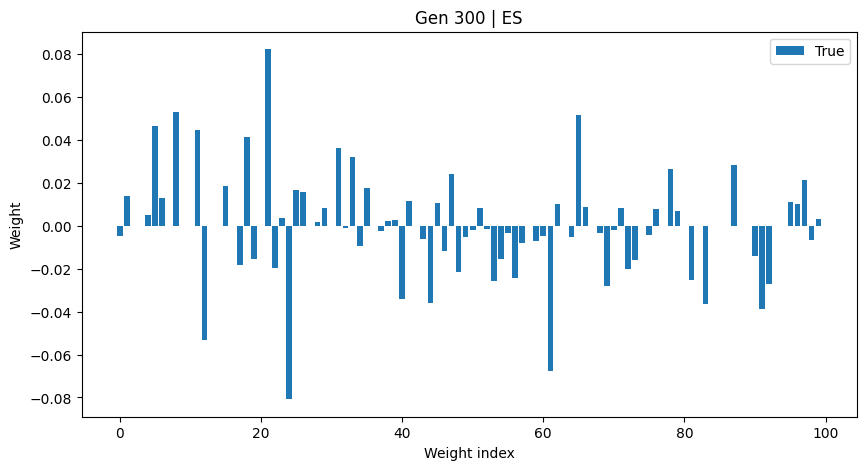

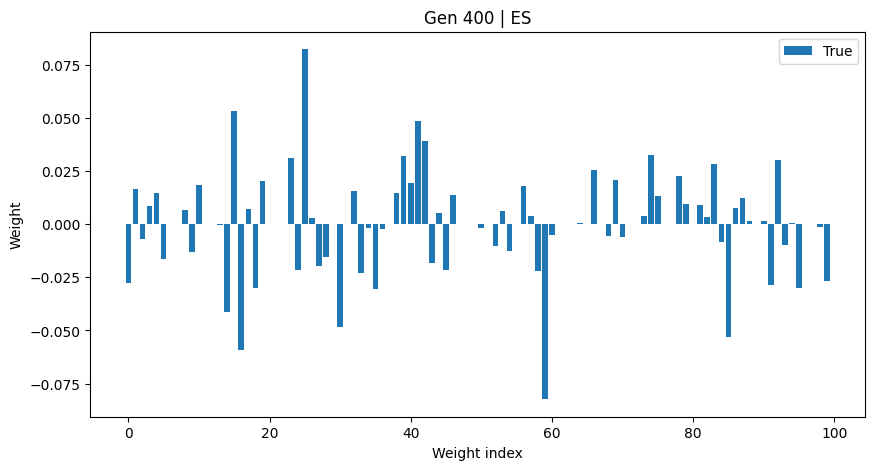

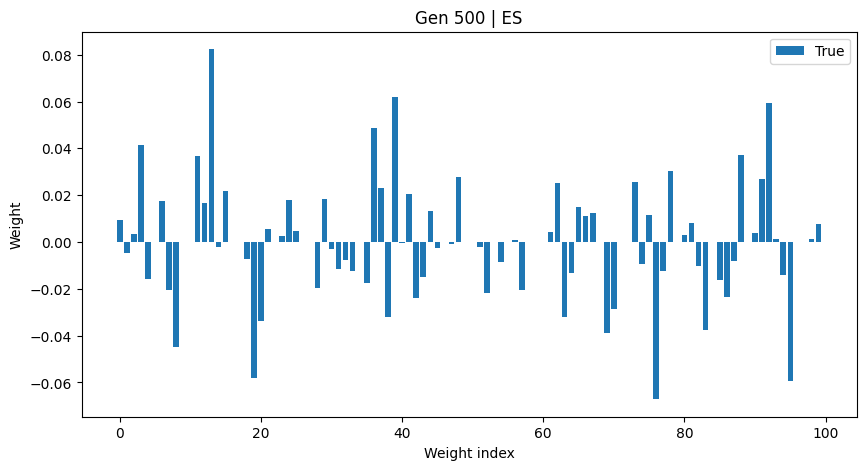

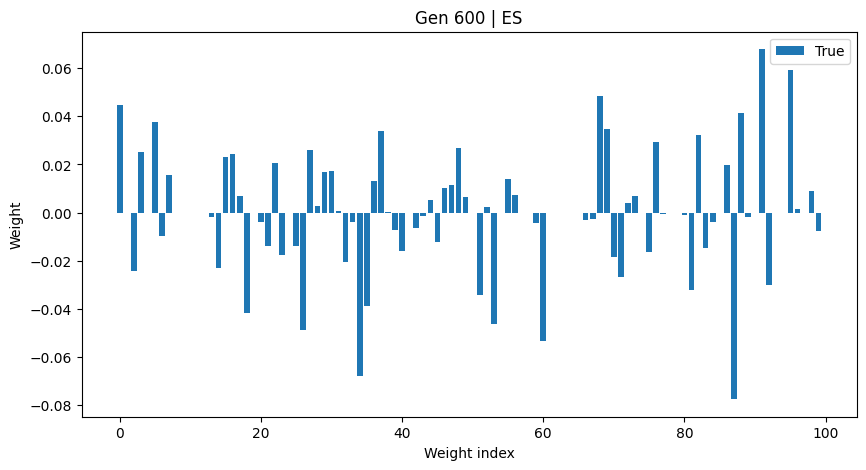

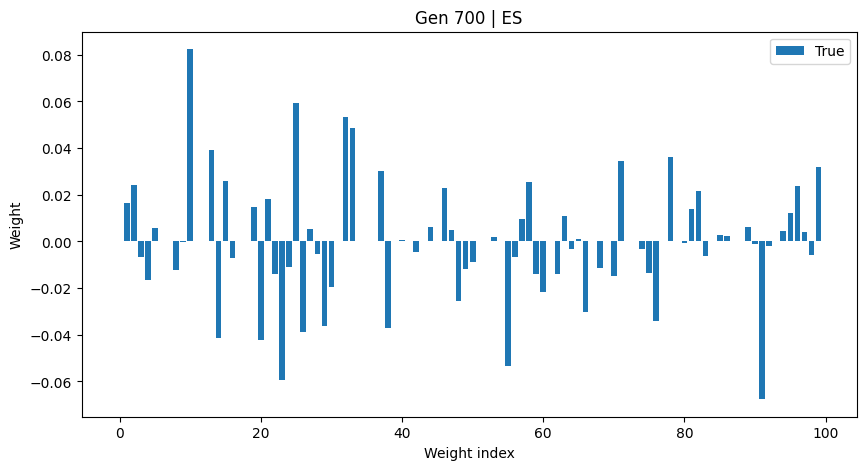

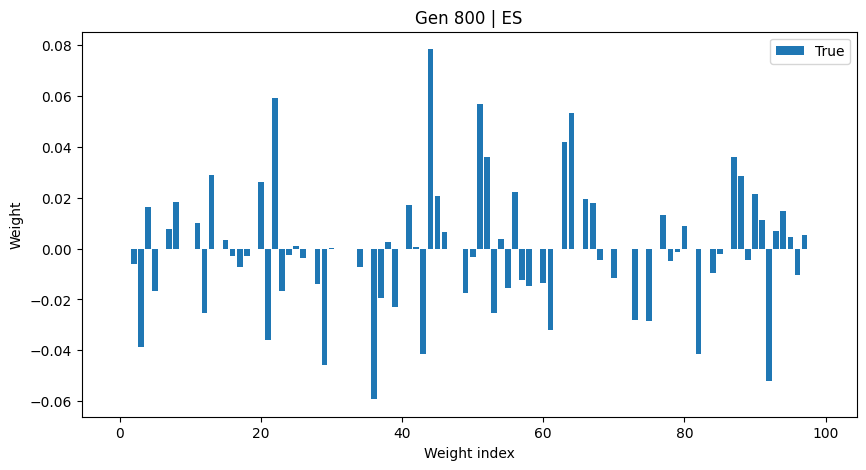

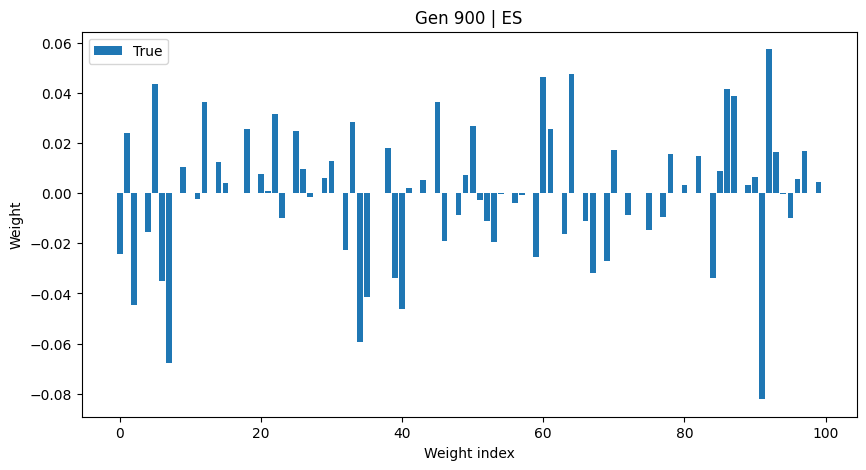

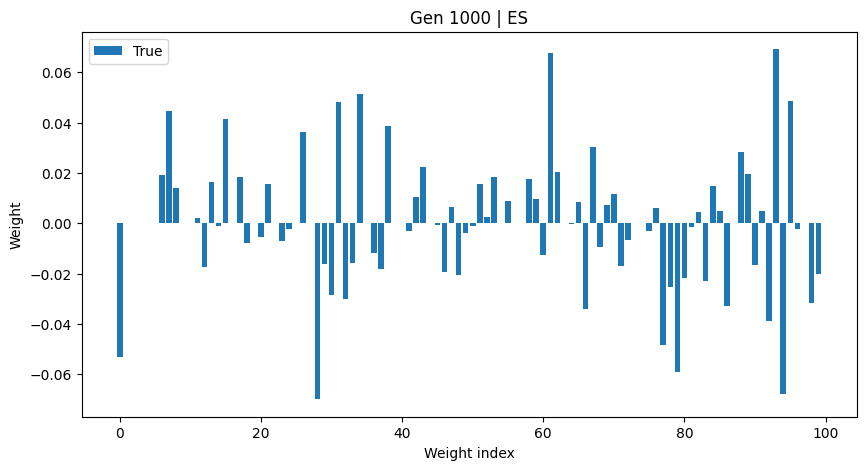

In [74]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, gen in enumerate(gens):
    fig, ax = plt.subplots(figsize=(10, 5))
    # bar plot of weights
    color = colors[i % len(colors)]

    fit_w = off_results[gen]["fit"]
    surr_fit_w = off_results[gen]["surr_fit"]
    random_w = off_results[gen]["random"]
    
    plt.bar(jnp.arange(len(fit_w)), fit_w-surr_fit_w, label="True")
    

    plt.xlabel("Weight index")
    plt.ylabel("Weight")
    plt.title(f"Gen {gen} | ES")
    plt.legend()
    plt.show()

In [65]:
def rbo(a, b):
  """Computes the rank-biased overlap between the rankings of two lists of scores.

  Args:
    a: A list of scores.
    b: A list of scores.

  Returns:
    The rank-biased overlap between the rankings of a and b.
  """

  # Check that the lists have the same length.
  if len(a) != len(b):
    raise ValueError("The lists must have the same length.")

  # Create a sorted list of the scores in a.
  a_sorted = sorted(a)

  # Create a sorted list of the scores in b.
  b_sorted = sorted(b)

  # Find the intersection of the two sorted lists.
  intersection = set(a_sorted).intersection(b_sorted)

  # Calculate the length of the intersection.
  intersection_length = len(intersection)

  # Calculate the length of the longer list.
  longer_list_length = max(len(a), len(b))

  # Return the RBO.
  return intersection_length / longer_list_length


In [ ]:
a, b = 

### Sensitivity

In [39]:
def get_surroundings(genes, n=101, sigma=0.2, n_evals=20):
    # Sample n points around the genes with a normal distribution
    noise = jax.random.normal(jax.random.PRNGKey(0), (n, genes.shape[0])) * sigma
    genomes = genes + noise
    
    batch_eval = min(n_evals, 20)

    num_batches = n_evals // batch_eval
    print(num_batches, "batches of", batch_eval, "evaluations each. Total:", num_batches * batch_eval)

    batch_fit = []
    from tqdm import tqdm
    for i in tqdm(range(num_batches)):
        fit = jax.vmap(multi_evals, in_axes=(0, None))(genomes, batch_eval)
        # print(fit.shape)
        batch_fit.append(fit)

    fitnesses = jnp.concatenate(batch_fit).reshape((num_batches, n)).mean(axis=0)

    distances = jnp.linalg.norm(noise, axis=1)
    
    return fitnesses, distances

In [1]:
gen = 1
n = 100
n_evals = 20
n_dist = 101

try:
    sigma_fits
except NameError:
    sigma_fits = {}
# sigma_fits = {}

gens = [1, 100, 200, 300, 400, 500, 600, 700, 800 ,900]
# gens = [1, 300, 700]

dx = 10
sigmas = jnp.linspace(0, dx, n_dist)[:, None]

for gen in gens:
    if gen in sigma_fits:
        print(f"Gen {gen:>4} already done. Skipping...")
        continue
    print("Gen", gen)
    genes = jnp.load(save_path + f"/gen_{gen}_offspring.npy")

    # Sample random directions with normalized length
    noise = jax.random.normal(jax.random.PRNGKey(0), (n, genes.shape[0]))
    noise = noise / jnp.linalg.norm(noise, axis=1)[:, None] # Normalize

    def sphere_fitness(sigma):
        genomes = genes + noise * sigma
        fit = jax.vmap(multi_evals, in_axes=(0, None))(genomes, 20)
        return fit.mean(axis=0)

    sigma_fits[gen] = jax.vmap(sphere_fitness)(sigmas)


NameError: name 'jnp' is not defined

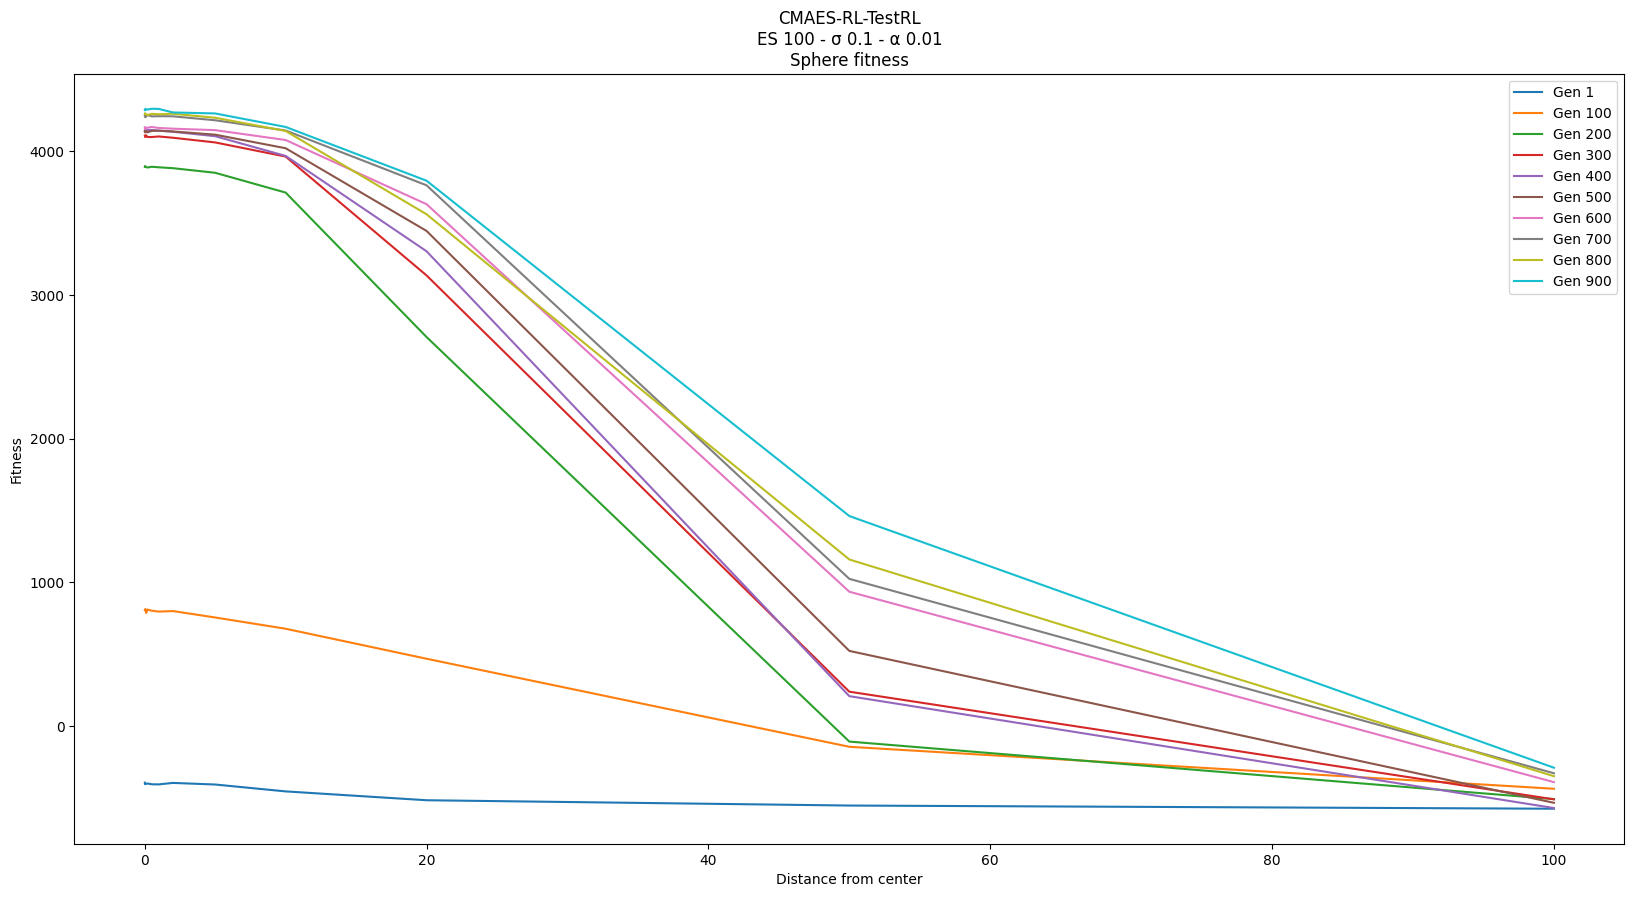

In [82]:
plt.figure(figsize=(20, 10))

to_plot = gens
# to_plot = [300, 700]

for gen in to_plot:
    plt.plot(sigmas, sigma_fits[gen], label=f"Gen {gen}")
plt.legend()
plt.xlabel("Distance from center")
plt.ylabel("Fitness")
# plt.xscale("log")
plt.title(f"{args.algo}\n{args.config}\nSphere fitness")
plt.show()

In [64]:
sigma_fits

DeviceArray([-392.33774, -402.75598, -399.64453, -400.8777 , -398.28613,
             -403.68976, -404.4356 , -394.18658, -405.3339 , -453.17828],            dtype=float32)

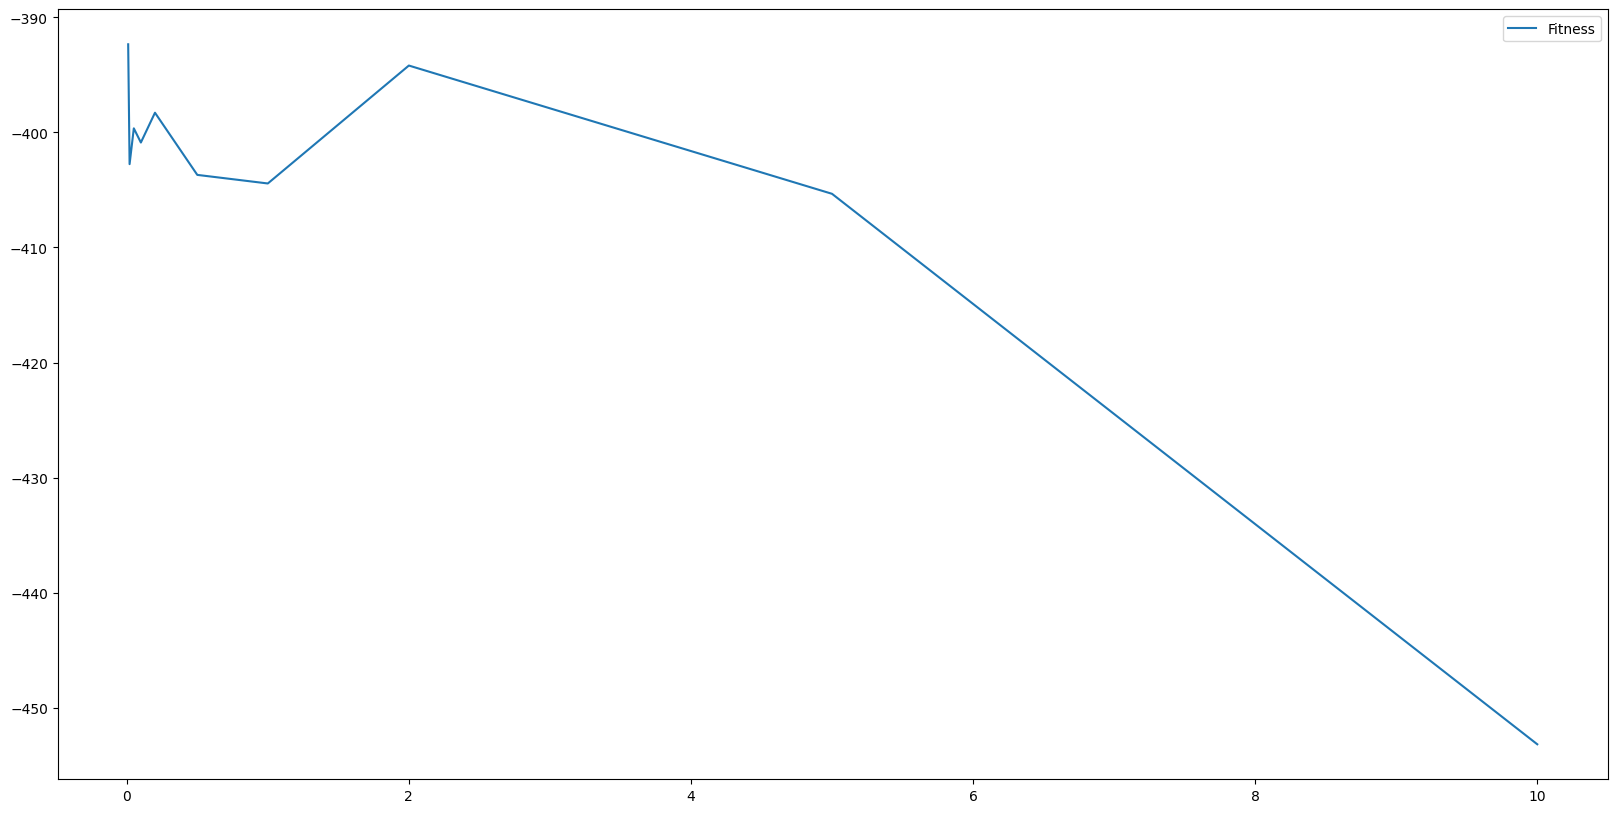

In [60]:
len(sigmas)

10

sigma = 0.01
1 batches of 20 evaluations each. Total: 20


100%|██████████| 1/1 [00:04<00:00,  4.02s/it]


sigma = 0.1
1 batches of 20 evaluations each. Total: 20


100%|██████████| 1/1 [00:03<00:00,  4.00s/it]


sigma = 1
1 batches of 20 evaluations each. Total: 20


100%|██████████| 1/1 [00:03<00:00,  4.00s/it]


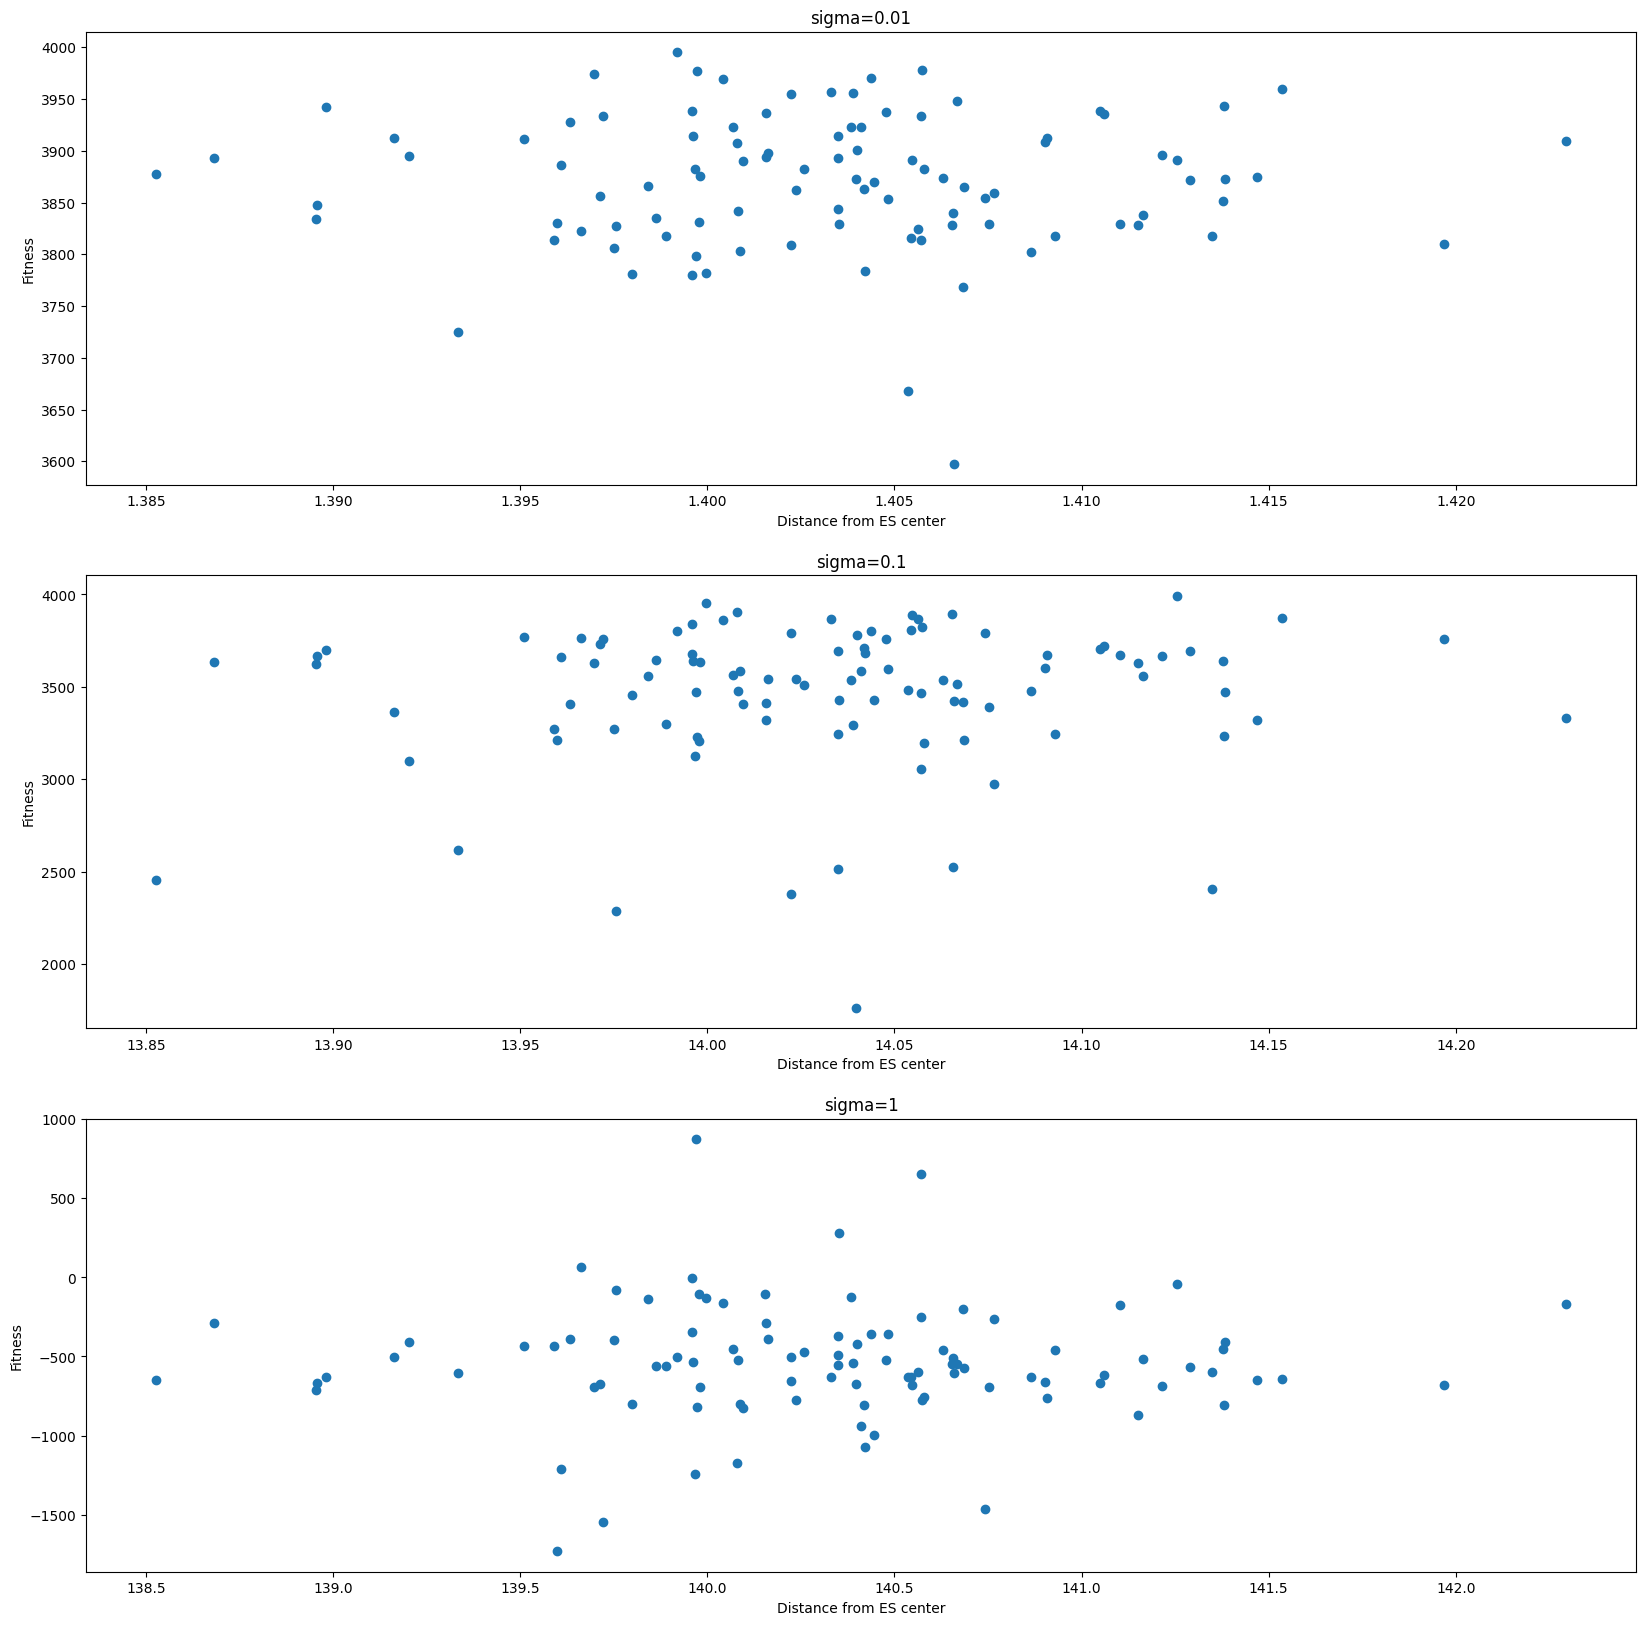

In [40]:
gen = 200
n = 100
genes = jnp.load(save_path + f"/gen_{gen}_offspring.npy")

sigmas = [0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10]
sigmas = [0.01, 0.1, 1]

# Make one subplot for each sigma
fig, axs = plt.subplots(len(sigmas), 1, figsize=(20, 20))

for i, sigma in enumerate(sigmas):
    print("sigma =", sigma)
    fit, dist = get_surroundings(genes, n=n, sigma=sigma)
    axs[i].scatter(dist, fit)
    axs[i].set_xlabel("Distance from ES center")
    axs[i].set_ylabel("Fitness")
    axs[i].set_title(f"sigma={sigma}")

plt.show()


In [7]:
gen = 489

offspring_genes = jnp.load(save_path + f"/gen_{gen}_offspring.npy")
actor_genes = jnp.load(save_path + f"/gen_{gen}_actor.npy")
critic_genes = jnp.load(save_path + f"/gen_{gen}_critic.npy")

In [8]:
offspring_genes.shape

(19718,)

In [9]:
es_center = emitter.es_emitter.unflatten(offspring_genes)
actor = emitter.es_emitter.unflatten(actor_genes)

In [10]:
# Distance
jnp.linalg.norm(offspring_genes - actor_genes)

DeviceArray(46.868362, dtype=float32)

In [54]:


multi_evals(actor_genes, 10)

DeviceArray(98.912415, dtype=float32)

In [78]:
n = 1001
# Interpolate between the two
genomes = jnp.linspace(0, 1, n)[:, None] * actor_genes + (1 - jnp.linspace(0, 1, n)[:, None]) * offspring_genes

# networks = jax.vmap(emitter.es_emitter.unflatten)(genomes)

x = jnp.linspace(0, 1, n)

In [79]:
genomes.shape

(1001, 19718)

In [90]:
n_evals = 100
batch_eval = 20

num_batches = n_evals // batch_eval
print(num_batches, "batches of", batch_eval, "evaluations each. Total:", num_batches * batch_eval)

batch_fit = []
from tqdm import tqdm
for i in tqdm(range(num_batches)):
    fit = jax.vmap(multi_evals, in_axes=(0, None))(genomes, batch_eval)
    # print(fit.shape)
    batch_fit.append(fit)

# batch_fit = jnp.concatenate(batch_fit)
# batch_fit.shape

5 batches of 20 evaluations each. Total: 100


 20%|██        | 1/5 [00:26<01:45, 26.39s/it]

(1001,)


 40%|████      | 2/5 [00:40<00:57, 19.07s/it]

(1001,)


 60%|██████    | 3/5 [00:54<00:33, 16.76s/it]

(1001,)


 80%|████████  | 4/5 [01:08<00:15, 15.69s/it]

(1001,)


100%|██████████| 5/5 [01:22<00:00, 16.49s/it]

(1001,)


AttributeError: 'list' object has no attribute 'shape'

In [91]:
batch_fit[0].shape

(1001,)

In [97]:
# Average over batches
fitnesses = jnp.concatenate(batch_fit).reshape((num_batches, n)).mean(axis=0)

fitnesses.shape

(1001,)

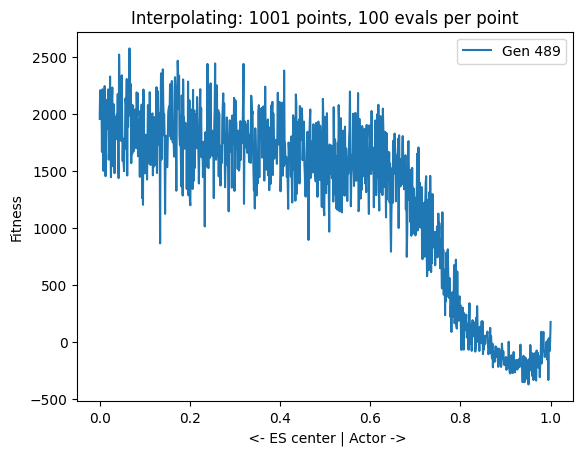

In [98]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(x, fitnesses, label = f"Gen {gen}")
plt.xlabel(" <- ES center | Actor ->")
plt.ylabel("Fitness")
plt.title(f"Interpolating: {n} points, {n_evals} evals per point")
plt.legend()

In [8]:
import jax 
from qdax import environments
from jax.flatten_util import ravel_pytree

from qdax.core.neuroevolution.networks.networks import MLP

policy_layer_sizes = config.policy_hidden_layer_sizes + (env.action_size,)
policy_network = MLP(
    layer_sizes=policy_layer_sizes,
    kernel_init=jax.nn.initializers.lecun_uniform(),
    final_activation=jnp.tanh,
)


random_key = jax.random.PRNGKey(0)
keys = jax.random.split(random_key, num=1)

env = environments.create(config.env_name, episode_length=config.episode_length)

fake_batch = jnp.zeros(shape=(1, env.observation_size))
init_variables = jax.vmap(policy_network.init)(keys, fake_batch)

_, reconstruction_fn = ravel_pytree(init_variables)

AttributeError: 'tuple' object has no attribute 'action_size'

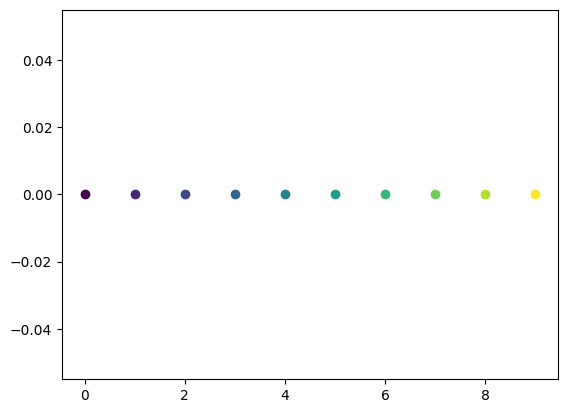

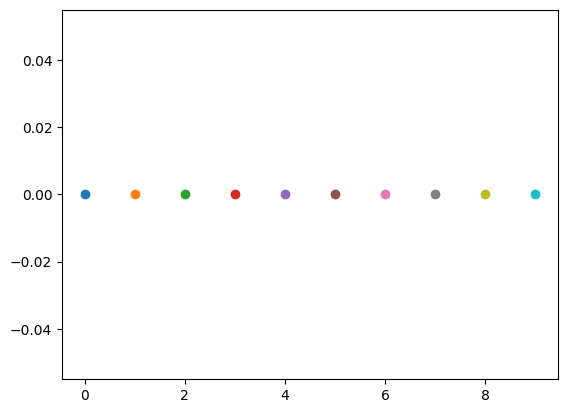

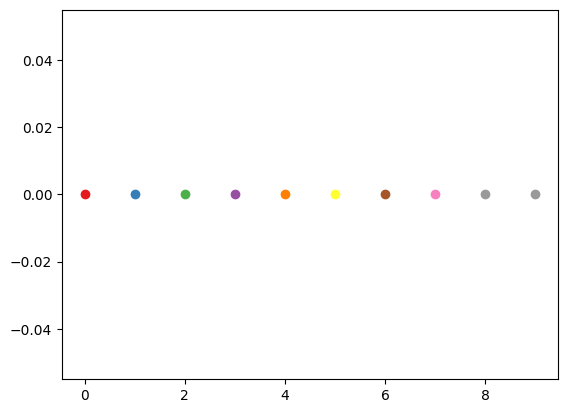

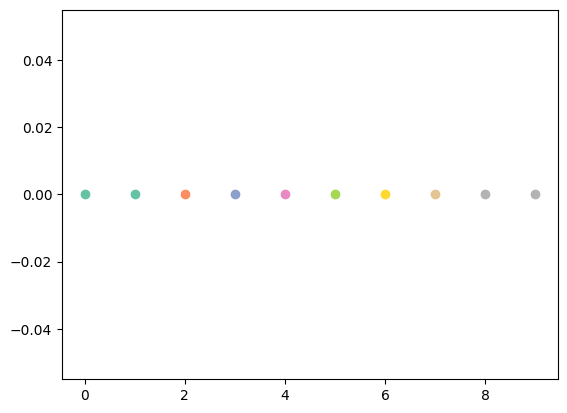

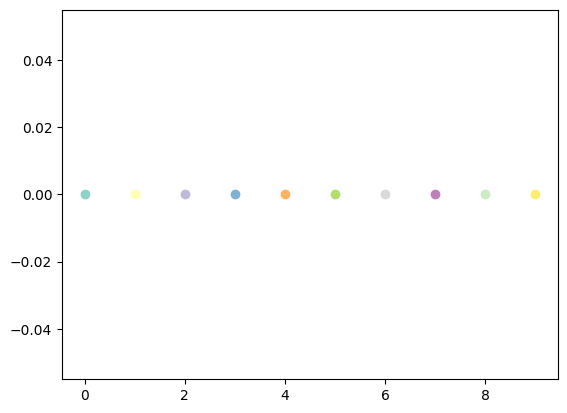

In [5]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
# Test color schemes with simple plot
n = 10
color_scheme = [
    plt.cm.viridis(jnp.linspace(0, 1, n)),
    plt.cm.tab10(jnp.linspace(0, 1, n)),
    plt.cm.Set1(jnp.linspace(0, 1, n)),
    plt.cm.Set2(jnp.linspace(0, 1, n)),
    plt.cm.Set3(jnp.linspace(0, 1, n)),
]

for colors in color_scheme:
    for i, c in enumerate(colors):
        plt.scatter(i, 0, color=c)
    plt.show()